# 🚀 PLDM for MiniGrid DoorKey - Complete Implementation

## Key Features:
- ✅ **Full RGB observations** (not partial view!)
- ✅ **Optimal BFS solver** (from working notebook)
- ✅ **Clean data collection** (80% optimal + 20% random)
- ✅ **Proper sequence extraction** (obs[t] → obs[t+1])
- ✅ **FlexibleEncoder** (auto-adapts to image size)
- ✅ **Rebalanced VICReg** (prediction-focused)
- ✅ **CEM Planner** (latent space planning)
- ✅ **Real environment evaluation**


In [1]:
# ============================================================================
# PLDM for MiniGrid - Clean Implementation with Full Observations
# ============================================================================

import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import minigrid
from minigrid.wrappers import FullyObsWrapper
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

# Setup
device = torch.device('mps' if torch.backends.mps.is_available() else 
                      'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# Environment with Full Observation
# ============================================================================

def make_env(env_name="MiniGrid-DoorKey-5x5-v0"):
    """Create environment with FULL RGB observation"""
    env = gym.make(env_name, render_mode='rgb_array')
    return env

def get_full_obs(env):
    """Get full RGB observation - downsampled for efficiency"""
    from PIL import Image
    
    # Use grid render with SMALLER tile size for efficiency
    if hasattr(env.unwrapped, 'grid'):
        tile_size = 8  # Much smaller! (was 32)
        grid = env.unwrapped.grid
        
        img = grid.render(
            tile_size,
            agent_pos=env.unwrapped.agent_pos,
            agent_dir=env.unwrapped.agent_dir,
            highlight_mask=None
        )
        
        return img
    else:
        return env.render()

# ============================================================================
# BFS Solver for Optimal Trajectories
# ============================================================================

def bfs_solve(env_name, seed):
    """
    Optimal BFS solver - from JEPA-sequences-augmented.ipynb
    Solves DoorKey by exploring grid positions and directions.
    """
    env = gym.make(env_name, render_mode=None)
    env.reset(seed=seed)
    unwrapped = env.unwrapped
    
    # Direction vectors: 0=Right, 1=Down, 2=Left, 3=Up
    DIR_TO_VEC = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    
    start_pos = unwrapped.agent_pos
    start_dir = unwrapped.agent_dir
    grid = unwrapped.grid
    
    # Queue: (x, y, dir, actions, carrying)
    queue = deque([(start_pos[0], start_pos[1], start_dir, [], None)])
    visited = set([(start_pos[0], start_pos[1], start_dir, None)])
    
    while queue:
        x, y, d, actions, carrying = queue.popleft()
        
        # Direction vector
        dx, dy = DIR_TO_VEC[d]
        fx, fy = x + dx, y + dy
        
        if 0 <= fx < grid.width and 0 <= fy < grid.height:
            cell = grid.get(fx, fy)
            
            # Check if we can reach goal
            if cell and cell.type == 'goal':
                env.close()
                return actions + [unwrapped.actions.forward]
            
            # Check if we can pick up key
            if cell and cell.type == 'key' and carrying is None:
                new_carrying = 'key'
                new_state = (x, y, d, new_carrying)
                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((x, y, d, actions + [unwrapped.actions.pickup], new_carrying))
            
            # Check if we can open door
            if cell and cell.type == 'door' and not cell.is_open:
                if carrying == 'key':
                    # Mark door as open in our search
                    new_state = (x, y, d, carrying)
                    queue.append((fx, fy, d, actions + [unwrapped.actions.toggle, unwrapped.actions.forward], carrying))
            
            # Check if we can move forward
            can_move = (cell is None) or \
                       (cell and cell.type == 'door' and cell.is_open) or \
                       (cell and cell.type == 'goal')
            
            if can_move:
                state = (fx, fy, d, carrying)
                if state not in visited:
                    visited.add(state)
                    queue.append((fx, fy, d, actions + [unwrapped.actions.forward], carrying))
        
        # Try turning left and right
        for turn in [-1, 1]:
            td = (d + turn) % 4
            state = (x, y, td, carrying)
            if state not in visited:
                visited.add(state)
                action_type = unwrapped.actions.left if turn == -1 else unwrapped.actions.right
                queue.append((x, y, td, actions + [action_type], carrying))
    
    env.close()
    return None

# ============================================================================
# Collect Trajectories
# ============================================================================

def collect_trajectory(env_name, seed, actions=None, max_steps=100):
    """
    Collect a single trajectory with full RGB observations.
    If actions provided, follow them (BFS trajectory).
    Otherwise, use random actions.
    """
    env = make_env(env_name)
    obs, _ = env.reset(seed=seed)
    
    trajectory = []
    
    if actions is None:
        # Random trajectory
        for step in range(max_steps):
            # Get full RGB observation
            rgb_obs = get_full_obs(env)
            
            action = env.action_space.sample()
            next_obs, reward, terminated, truncated, info = env.step(action)
            
            trajectory.append({
                'obs': rgb_obs.copy(),
                'action': action,
                'reward': reward,
                'terminated': terminated
            })
            
            obs = next_obs
            
            if terminated or truncated:
                final_obs = get_full_obs(env)
                trajectory.append({'obs': final_obs.copy(), 'action': -1, 'reward': 0.0, 'terminated': True})
                break
    else:
        # Follow provided actions (BFS)
        for action in actions:
            # Get full RGB observation
            rgb_obs = get_full_obs(env)
            
            next_obs, reward, terminated, truncated, info = env.step(action)
            
            trajectory.append({
                'obs': rgb_obs.copy(),
                'action': action,
                'reward': reward,
                'terminated': terminated
            })
            
            obs = next_obs
            
            if terminated:
                final_obs = get_full_obs(env)
                trajectory.append({'obs': final_obs.copy(), 'action': -1, 'reward': 0.0, 'terminated': True})
                break
    
    env.close()
    return trajectory if len(trajectory) > 0 else None

def collect_dataset(env_name="MiniGrid-DoorKey-5x5-v0", 
                   num_trajectories=100,
                   bfs_ratio=0.8,
                   max_steps=100):
    """
    Collect dataset with mix of BFS (optimal) and random trajectories.
    
    Args:
        bfs_ratio: Fraction of trajectories that should be BFS-solved (optimal)
    """
    num_bfs = int(num_trajectories * bfs_ratio)
    num_random = num_trajectories - num_bfs
    bfs_seeds = [0 + i for i in range(num_bfs * 3)]  # Extra for retries
    random_seeds = [4000 + i for i in range(num_random)]
    
    trajectories = []
    
    # Collect BFS trajectories
    print(f"Collecting {num_bfs} BFS trajectories...")
    attempts = 0
    bfs_index = 0
    with tqdm(total=num_bfs) as pbar:
        while len([t for t in trajectories if t]) < num_bfs and attempts < num_bfs * 3:
            #seed = random.randint(0, 100000)
            actions = bfs_solve(env_name, bfs_seeds[bfs_index])
            
            if actions is not None:
                traj = collect_trajectory(env_name, bfs_seeds[bfs_index], actions=actions)
                if traj and len(traj) > 5:
                    trajectories.append(traj)
                    pbar.update(1)
            
            attempts += 1
            bfs_index += 1
    
    # Collect random trajectories
    print(f"\nCollecting {num_random} random trajectories...")
    random_index = 0
    for _ in tqdm(range(num_random)):
        #seed = random.randint(0, 100000)
        traj = collect_trajectory(env_name, random_seeds[random_index], actions=None, max_steps=max_steps)
        random_index += 1
        if traj and len(traj) > 5:
            trajectories.append(traj)
    
    print(f"\n✓ Collected {len(trajectories)} trajectories")
    print(f"  Total transitions: {sum(len(t) for t in trajectories)}")
    print(f"  Avg trajectory length: {np.mean([len(t) for t in trajectories]):.1f}")
    
    return trajectories

print("Setup complete - ready to collect data")
print("Using render_mode='rgb_array' for FULL RGB observations (not encoded grid)")


/Users/apurva/Downloads/jepa/jepa_env/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Using device: mps
Setup complete - ready to collect data
Using render_mode='rgb_array' for FULL RGB observations (not encoded grid)


In [15]:
# ============================================================================
# Collect Dataset
# ============================================================================

trajectories = collect_dataset(
    env_name="MiniGrid-DoorKey-5x5-v0",
    num_trajectories=1200,  # Start small for testing
    bfs_ratio=0.80,  # 80% optimal, 20% random
    max_steps=100
)


100%|██████████| 960/960 [00:02<00:00, 387.89it/s]


100%|██████████| 240/240 [00:04<00:00, 57.32it/s]


✓ Collected 1200 trajectories
  Total transitions: 34099
  Avg trajectory length: 28.4


Visualizing trajectory 0
Length: 8 steps
Successful: False


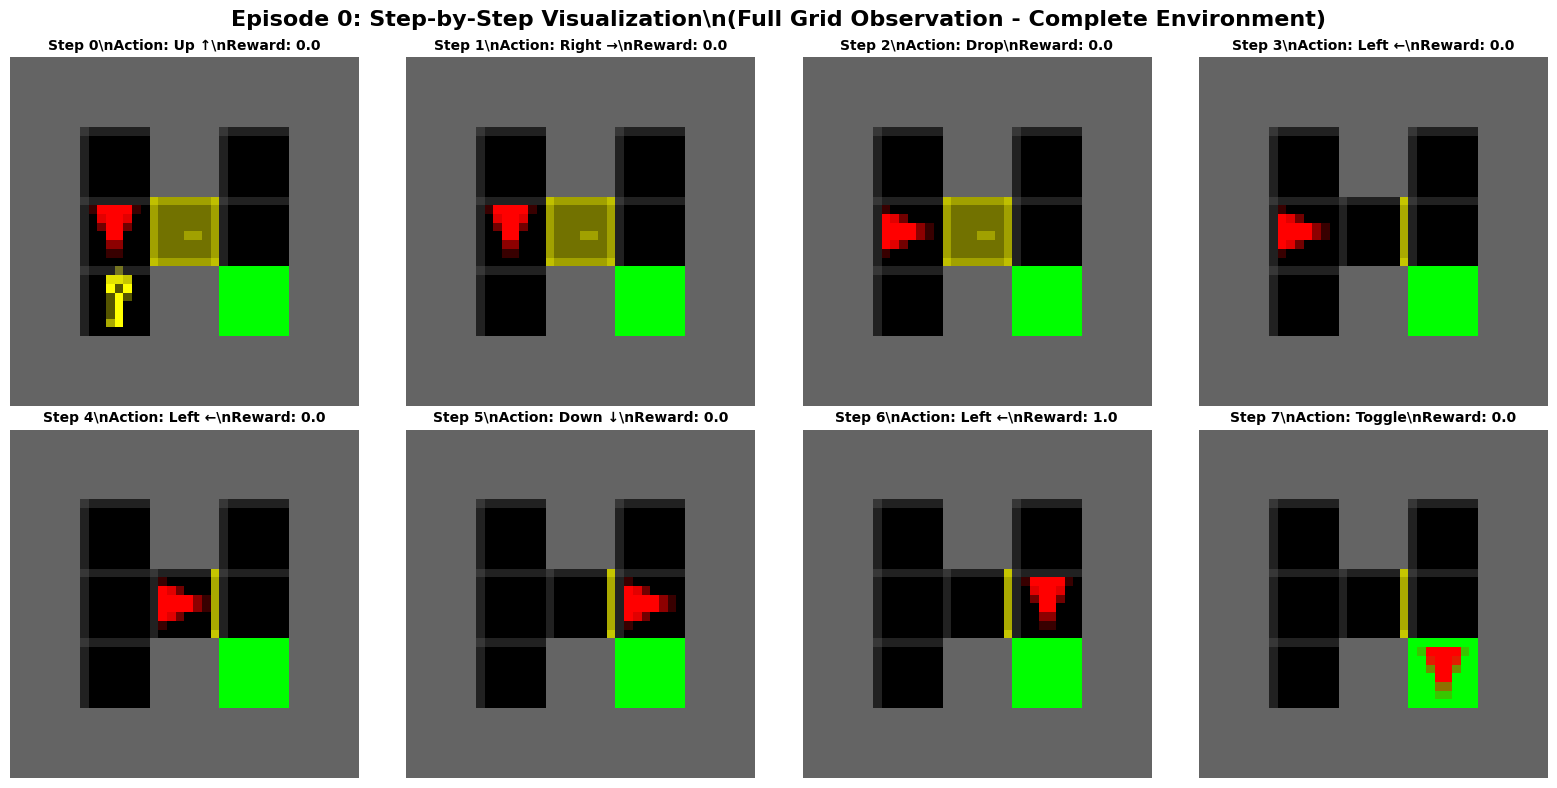

\nVerifying observations change between consecutive steps:
  ✓ Step 0→1: diff = 0.5150
  ✓ Step 1→2: diff = 0.6400
  ✓ Step 2→3: diff = 3.1867
  ✓ Step 3→4: diff = 1.0667
  ✓ Step 4→5: diff = 1.0667
  ✓ Step 5→6: diff = 0.6400
  ✓ Step 6→7: diff = 1.3533
\n7/7 steps show significant changes
✓ Dataset looks good - observations are changing properly!


In [16]:
# ============================================================================
# Visualize Complete Episode Step-by-Step
# ============================================================================

# Pick a trajectory to visualize
traj_idx = 0
trajectory = trajectories[traj_idx]

print(f"Visualizing trajectory {traj_idx}")
print(f"Length: {len(trajectory)} steps")
print(f"Successful: {trajectory[-1]['terminated'] and trajectory[-1]['reward'] > 0}")

# Visualize every step
num_steps = min(len(trajectory), 16)  # Show first 16 steps
cols = 4
rows = (num_steps + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

action_names = ['Right →', 'Down ↓', 'Left ←', 'Up ↑', 'Pick', 'Drop', 'Toggle']

for i in range(num_steps):
    trans = trajectory[i]
    obs = trans['obs']
    action = trans['action']
    reward = trans['reward']
    
    axes[i].imshow(obs)
    axes[i].set_title(f"Step {i}\\nAction: {action_names[action]}\\nReward: {reward:.1f}", 
                     fontsize=10, fontweight='bold')
    axes[i].axis('off')

# Hide unused subplots
for i in range(num_steps, len(axes)):
    axes[i].axis('off')

plt.suptitle(f"Episode {traj_idx}: Step-by-Step Visualization\\n(Full Grid Observation - Complete Environment)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Verify observations are changing
print("\\nVerifying observations change between consecutive steps:")
changes_good = 0
for i in range(min(10, len(trajectory)-1)):
    obs1 = trajectory[i]['obs']
    obs2 = trajectory[i+1]['obs']
    diff = np.abs(obs2 - obs1).mean()
    status = "✓" if diff > 0.1 else "✗"
    print(f"  {status} Step {i}→{i+1}: diff = {diff:.4f}")
    if diff > 0.1:
        changes_good += 1

print(f"\\n{changes_good}/{min(10, len(trajectory)-1)} steps show significant changes")

if changes_good >= 5:
    print("✓ Dataset looks good - observations are changing properly!")
else:
    print("❌ WARNING: Observations not changing enough!")


Visualizing BFS-solved trajectories from different seeds...


Seed 1: BFS Solution with 7 actions
  Step 1: Pick  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 2: Left  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 3: Tog   → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 4: Fwd   → pos=(np.int64(2), np.int64(2)), reward=0.0, done=False
  Step 5: Fwd   → pos=(np.int64(3), np.int64(2)), reward=0.0, done=False
  Step 6: Right → pos=(np.int64(3), np.int64(2)), reward=0.0, done=False
  Step 7: Fwd   → pos=(np.int64(3), np.int64(3)), reward=1.0, done=True

✅ Task completed in 7 steps!


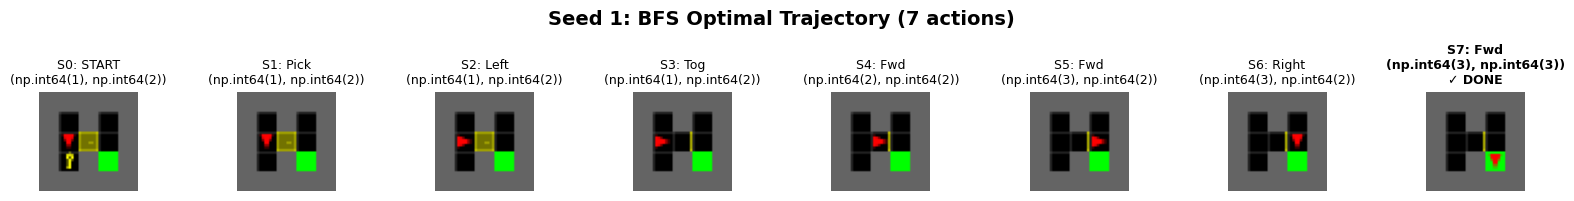


Seed 2: BFS Solution with 13 actions
  Step 1: Right → pos=(np.int64(1), np.int64(1)), reward=0.0, done=False
  Step 2: Fwd   → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 3: Pick  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 4: Left  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 5: Left  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 6: Fwd   → pos=(np.int64(1), np.int64(1)), reward=0.0, done=False
  Step 7: Right → pos=(np.int64(1), np.int64(1)), reward=0.0, done=False
  Step 8: Tog   → pos=(np.int64(1), np.int64(1)), reward=0.0, done=False
  Step 9: Fwd   → pos=(np.int64(2), np.int64(1)), reward=0.0, done=False
  Step 10: Fwd   → pos=(np.int64(3), np.int64(1)), reward=0.0, done=False
  Step 11: Right → pos=(np.int64(3), np.int64(1)), reward=0.0, done=False
  Step 12: Fwd   → pos=(np.int64(3), np.int64(2)), reward=0.0, done=False
  Step 13: Fwd   → pos=(np.int64(3), np.int64(3)), reward=1.0, done=True

✅ Task co

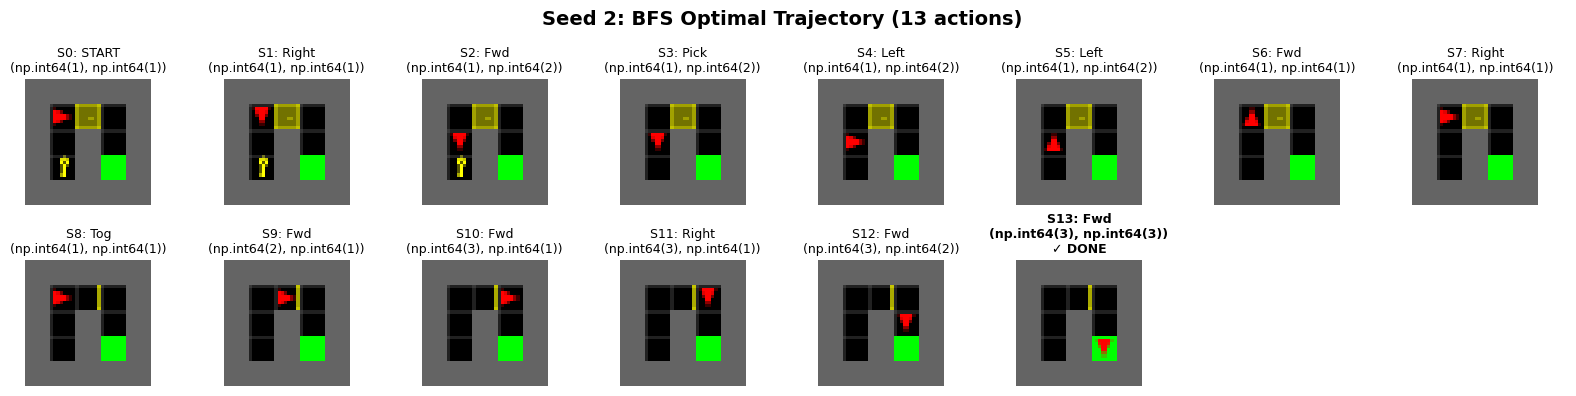


Seed 4: BFS Solution with 7 actions
  Step 1: Pick  → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 2: Right → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 3: Tog   → pos=(np.int64(1), np.int64(2)), reward=0.0, done=False
  Step 4: Fwd   → pos=(np.int64(2), np.int64(2)), reward=0.0, done=False
  Step 5: Fwd   → pos=(np.int64(3), np.int64(2)), reward=0.0, done=False
  Step 6: Right → pos=(np.int64(3), np.int64(2)), reward=0.0, done=False
  Step 7: Fwd   → pos=(np.int64(3), np.int64(3)), reward=1.0, done=True

✅ Task completed in 7 steps!


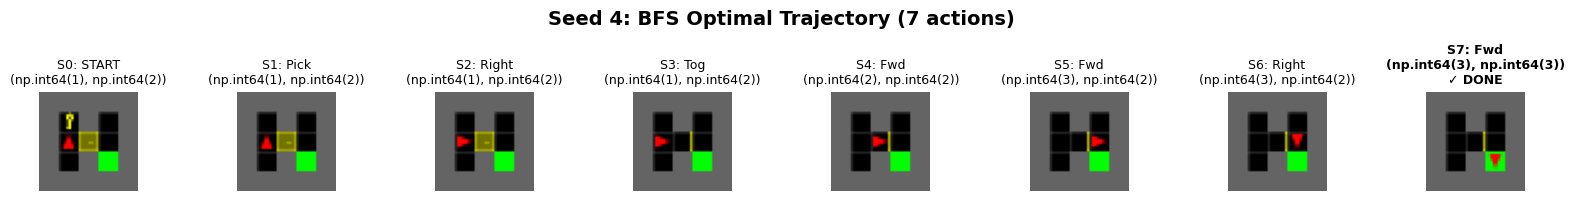

In [17]:

# ============================================================================
# Visualize BFS-Solved Trajectories
# ============================================================================

def visualize_bfs_trajectory(seed):
    """Visualize a complete BFS-solved trajectory"""
    # Get BFS solution
    actions = bfs_solve("MiniGrid-DoorKey-5x5-v0", seed)
    
    if actions is None:
        print(f"Seed {seed}: BFS failed to find solution")
        return None
    
    print(f"\n{'='*70}")
    print(f"Seed {seed}: BFS Solution with {len(actions)} actions")
    print(f"{'='*70}")
    
    # Collect trajectory
    env = make_env("MiniGrid-DoorKey-5x5-v0")
    env.reset(seed=seed)
    
    images = []
    positions = []
    action_taken = []
    rewards = []
    dones = []
    
    # Initial state
    images.append(get_full_obs(env).copy())
    positions.append(tuple(env.unwrapped.agent_pos))
    
    # Execute actions
    action_names = ['Left', 'Right', 'Fwd', 'Pick', 'Drop', 'Tog', 'Done']
    for i, action in enumerate(actions):
        obs, reward, done, truncated, _ = env.step(action)
        
        images.append(get_full_obs(env).copy())
        positions.append(tuple(env.unwrapped.agent_pos))
        action_taken.append(action)
        rewards.append(reward)
        dones.append(done)
        
        print(f"  Step {i+1}: {action_names[action]:5s} → pos={env.unwrapped.agent_pos}, "
              f"reward={reward:.1f}, done={done}")
        
        if done:
            print(f"\n✅ Task completed in {i+1} steps!")
            break
    
    env.close()
    
    # Visualize
    num_images = len(images)
    cols = min(8, num_images)
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx in range(num_images):
        row, col = idx // cols, idx % cols
        axes[row, col].imshow(images[idx])
        
        if idx == 0:
            title = f'S0: START\n{positions[idx]}'
        else:
            title = f'S{idx}: {action_names[action_taken[idx-1]]}\n{positions[idx]}'
            if dones[idx-1]:
                title += '\n✓ DONE'
        
        axes[row, col].set_title(title, fontsize=9, fontweight='bold' if idx == num_images-1 else 'normal')
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for idx in range(num_images, rows * cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')
    
    fig.suptitle(f'Seed {seed}: BFS Optimal Trajectory ({len(actions)} actions)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return images, actions

# Visualize multiple BFS trajectories
print("Visualizing BFS-solved trajectories from different seeds...\n")

for seed in [1, 2, 4]:  # Seeds we know work from earlier test
    visualize_bfs_trajectory(seed)


In [18]:
# ============================================================================
# Dataset Class
# ============================================================================

from torch.utils.data import Dataset, DataLoader

class TrajectoryDataset(Dataset):
    """
    Extract observation sequences from trajectories for dynamics learning.
    Returns: obs[0:T], actions[0:T], obs[1:T+1]
    """
    def __init__(self, trajectories, sequence_length=8):
        self.trajectories = trajectories
        self.sequence_length = sequence_length
        
        # Find valid starting points
        self.valid_starts = []
        for traj_idx, traj in enumerate(trajectories):
            # Need sequence_length+1 observations (obs[0] through obs[sequence_length])
            for start_idx in range(len(traj) - sequence_length):
                self.valid_starts.append((traj_idx, start_idx))
        
        print(f"✓ Dataset: {len(self.valid_starts)} sequences from {len(trajectories)} trajectories")
    
    def __len__(self):
        return len(self.valid_starts)
    
    def __getitem__(self, idx):
        traj_idx, start_idx = self.valid_starts[idx]
        trajectory = self.trajectories[traj_idx]
        
        # Extract sequence
        observations = []
        actions = []
        
        for i in range(self.sequence_length):
            trans = trajectory[start_idx + i]
            observations.append(trans['obs'])
            actions.append(trans['action'])
        
        # Next observations (shifted by 1)
        next_observations = []
        for i in range(self.sequence_length):
            trans_next = trajectory[start_idx + i + 1]
            next_observations.append(trans_next['obs'])
        
        # Convert to tensors
        # RGB observations: (seq, H, W, 3) -> (seq, 3, H, W), normalize to [0, 1]
        observations = torch.FloatTensor(np.array(observations)).permute(0, 3, 1, 2) / 255.0
        next_observations = torch.FloatTensor(np.array(next_observations)).permute(0, 3, 1, 2) / 255.0
        actions = torch.LongTensor(actions)
        
        return observations, actions, next_observations

print("✓ TrajectoryDataset defined")


✓ TrajectoryDataset defined


In [2]:
# ============================================================================
# Model Architecture
# ============================================================================

import torch.nn.functional as F

class FlexibleEncoder(nn.Module):
    """Encoder that auto-adapts to any observation size"""
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Conv layers (preserve spatial dimensions)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc = None  # Will be initialized on first forward pass
    
    def _init_fc(self, conv_out_size):
        """Initialize FC layers based on actual conv output"""
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.latent_dim)
        ).to(next(self.conv.parameters()).device)
    
    def forward(self, x):
        if x.dim() == 5:  # Sequence: (batch, seq, C, H, W)
            B, T = x.shape[:2]
            x = x.reshape(B * T, *x.shape[2:])
            conv_out = self.conv(x)
            
            if self.fc is None:
                self._init_fc(conv_out.shape[1])
            
            z = self.fc(conv_out)
            return z.reshape(B, T, self.latent_dim)
        else:  # Single: (batch, C, H, W)
            conv_out = self.conv(x)
            
            if self.fc is None:
                self._init_fc(conv_out.shape[1])
            
            return self.fc(conv_out)


class Predictor(nn.Module):
    """Dynamics predictor: (z_t, action) -> z_{t+1}"""
    def __init__(self, latent_dim=128, action_dim=7):
        super().__init__()
        self.latent_dim = latent_dim
        self.action_embed = nn.Embedding(action_dim, latent_dim)
        
        self.dynamics = nn.Sequential(
            nn.Linear(latent_dim * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
    
    def forward(self, z, action):
        if z.dim() == 3:  # Sequence
            B, T, _ = z.shape
            z_flat = z.reshape(B * T, self.latent_dim)
            action_flat = action.reshape(B * T)
            action_emb = self.action_embed(action_flat)
            x = torch.cat([z_flat, action_emb], dim=-1)
            z_next = z_flat + self.dynamics(x)  # Residual
            return z_next.reshape(B, T, self.latent_dim)
        else:  # Single
            action_emb = self.action_embed(action)
            x = torch.cat([z, action_emb], dim=-1)
            return z + self.dynamics(x)  # Residual


class PLDM(nn.Module):
    """Complete PLDM: Encoder + Predictor"""
    def __init__(self, latent_dim=128, action_dim=7):
        super().__init__()
        self.encoder = FlexibleEncoder(latent_dim)
        self.predictor = Predictor(latent_dim, action_dim)
        self.latent_dim = latent_dim
    
    def forward(self, obs, actions, next_obs):
        z = self.encoder(obs)
        z_next = self.encoder(next_obs)
        z_next_pred = self.predictor(z, actions)
        return z, z_next, z_next_pred
    
    def encode(self, obs):
        return self.encoder(obs)
    
    def predict_step(self, z, action):
        return self.predictor(z, action)

print("✓ Model architecture defined")


✓ Model architecture defined


In [20]:
# ============================================================================
# VICReg Loss & Training
# ============================================================================

import torch.optim as optim
import os

def vicreg_loss(z_pred, z_target, sim_coeff=1.0, std_coeff=1.0, cov_coeff=0.04):
    z_target = z_target.detach()
    sim_loss = F.mse_loss(z_pred, z_target)
    z_flat = z_pred.reshape(-1, z_pred.shape[-1]) if z_pred.dim() == 3 else z_pred
    B, D = z_flat.shape
    z_centered = z_flat - z_flat.mean(dim=0, keepdim=True)
    std = torch.sqrt(z_centered.var(dim=0) + 1e-4)
    std_loss = F.relu(1.0 - std).mean()
    cov = (z_centered.T @ z_centered) / (B - 1)
    cov_loss = (cov ** 2).sum() - (torch.diagonal(cov) ** 2).sum()
    cov_loss = cov_loss / (D * (D - 1))
    total_loss = sim_coeff * sim_loss + std_coeff * std_loss + cov_coeff * cov_loss
    return total_loss, sim_loss, std_loss, cov_loss

def vicreg_loss_two(z_pred, z_target, sim_coeff=1.0, std_coeff=1.0, cov_coeff=0.04):
    # Flatten both the same way
    def flatten(z):
        return z.reshape(-1, z.shape[-1]) if z.dim() == 3 else z

    z_pred = flatten(z_pred)
    z_target = flatten(z_target).detach()

    B, D = z_pred.shape

    # Loss 1: invariance (MSE)
    sim_loss = F.mse_loss(z_pred, z_target)

    # Standardize (per dim)
    z_centered = z_pred - z_pred.mean(dim=0, keepdim=True)

    # Loss 2: variance term
    std = torch.sqrt(z_centered.var(dim=0, unbiased=False) + 1e-4)
    std_loss = F.relu(1.0 - std).mean()

    # Loss 3: covariance (VICReg official)
    cov = (z_centered.T @ z_centered) / B
    off_diag = cov - torch.diag(torch.diag(cov))
    cov_loss = off_diag.pow(2).sum() / D

    # Weighted total loss
    total_loss = sim_coeff * sim_loss + std_coeff * std_loss + cov_coeff * cov_loss
    return total_loss, sim_loss, std_loss, cov_loss


def train_pldm(model, train_loader, val_loader, num_epochs=60, lr=3e-4,
               sim_coeff=1.0, std_coeff=1.0, cov_coeff=0.04, save_dir='checkpoints'):
    os.makedirs(save_dir, exist_ok=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'train_sim': [], 'train_std': [], 'train_cov': [],
        'val_loss': [], 'val_sim': [], 'val_std': [], 'val_cov': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = {'total': [], 'sim': [], 'std': [], 'cov': []}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for obs, actions, next_obs in pbar:
            obs, actions, next_obs = obs.to(device), actions.to(device), next_obs.to(device)
            z, z_next, z_next_pred = model(obs, actions, next_obs)
            total_loss, sim_loss, std_loss, cov_loss = vicreg_loss(z_next_pred, z_next, sim_coeff, std_coeff, cov_coeff)
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_losses['total'].append(total_loss.item())
            train_losses['sim'].append(sim_loss.item())
            train_losses['std'].append(std_loss.item())
            train_losses['cov'].append(cov_loss.item())
            pbar.set_postfix({'loss': total_loss.item(), 'sim': sim_loss.item()})
        
        if (epoch + 1) % 5 == 0:
            model.eval()
            val_losses = {'total': [], 'sim': [], 'std': [], 'cov': []}
            with torch.no_grad():
                for obs, actions, next_obs in val_loader:
                    obs, actions, next_obs = obs.to(device), actions.to(device), next_obs.to(device)
                    z, z_next, z_next_pred = model(obs, actions, next_obs)
                    total_loss, sim_loss, std_loss, cov_loss = vicreg_loss(z_next_pred, z_next, sim_coeff, std_coeff, cov_coeff)
                    val_losses['total'].append(total_loss.item())
                    val_losses['sim'].append(sim_loss.item())
                    val_losses['std'].append(std_loss.item())
                    val_losses['cov'].append(cov_loss.item())
            val_loss = np.mean(val_losses['total'])
            val_sim = np.mean(val_losses['sim'])
            val_std = np.mean(val_losses['std'])
            val_cov = np.mean(val_losses['cov'])
            print(f"\nEpoch {epoch+1}: Train={np.mean(train_losses['total']):.4f}, Val={val_loss:.4f}, "
                  f"Sim={val_sim:.4f}, Std={val_std:.4f}, Cov={val_cov:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"{save_dir}/best_model.pt")
                print(f"  Saved best (val_loss={val_loss:.4f})")
        
        history['train_loss'].append(np.mean(train_losses['total']))
        history['train_sim'].append(np.mean(train_losses['sim']))
        history['train_std'].append(np.mean(train_losses['std']))
        history['train_cov'].append(np.mean(train_losses['cov']))
        if (epoch + 1) % 5 == 0:
            history['val_loss'].append(val_loss)
            history['val_sim'].append(val_sim)
            history['val_std'].append(val_std)
            history['val_cov'].append(val_cov)
    
    return history

print("✓ Training functions defined")


✓ Training functions defined


In [22]:
# ============================================================================
# Prepare Dataset and Train
# ============================================================================

# Create dataset
dataset = TrajectoryDataset(trajectories, sequence_length=8)

# Split train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train: {len(train_dataset)} sequences")
print(f"Val: {len(val_dataset)} sequences")

# Create model
model = PLDM(latent_dim=128, action_dim=7).to(device)
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\nTraining PLDM...")
history = train_pldm(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=3e-4,
    sim_coeff=1.0,  # Rebalanced for better dynamics learning
    std_coeff=1.0,
    cov_coeff=0.04,
    save_dir='pldm_checkpoints'
)


✓ Dataset: 24499 sequences from 1200 trajectories
Train: 19599 sequences
Val: 4900 sequences

Model parameters: 554,048

Training PLDM...


Epoch 5/100: 100%|██████████| 307/307 [00:21<00:00, 14.08it/s, loss=0.125, sim=0.0844]



Epoch 5: Train=0.1254, Val=0.1167, Sim=0.0791, Std=0.0226, Cov=0.3761
  Saved best (val_loss=0.1167)


Epoch 10/100: 100%|██████████| 307/307 [00:21<00:00, 14.08it/s, loss=0.0944, sim=0.0343]



Epoch 10: Train=0.0690, Val=0.0641, Sim=0.0339, Std=0.0159, Cov=0.3575
  Saved best (val_loss=0.0641)


Epoch 15/100: 100%|██████████| 307/307 [00:21<00:00, 14.07it/s, loss=0.104, sim=0.0195] 



Epoch 15: Train=0.0467, Val=0.0457, Sim=0.0205, Std=0.0109, Cov=0.3571
  Saved best (val_loss=0.0457)


Epoch 20/100: 100%|██████████| 307/307 [00:21<00:00, 14.05it/s, loss=0.0637, sim=0.0145]



Epoch 20: Train=0.0382, Val=0.0375, Sim=0.0150, Std=0.0067, Cov=0.3936
  Saved best (val_loss=0.0375)


Epoch 25/100: 100%|██████████| 307/307 [00:21<00:00, 14.05it/s, loss=0.065, sim=0.00994] 



Epoch 25: Train=0.0336, Val=0.0327, Sim=0.0112, Std=0.0058, Cov=0.3917
  Saved best (val_loss=0.0327)


Epoch 30/100: 100%|██████████| 307/307 [00:21<00:00, 14.02it/s, loss=0.0533, sim=0.00768]



Epoch 30: Train=0.0299, Val=0.0298, Sim=0.0078, Std=0.0067, Cov=0.3819
  Saved best (val_loss=0.0298)


Epoch 35/100: 100%|██████████| 307/307 [00:21<00:00, 14.09it/s, loss=0.0488, sim=0.00558]



Epoch 35: Train=0.0276, Val=0.0272, Sim=0.0062, Std=0.0053, Cov=0.3949
  Saved best (val_loss=0.0272)


Epoch 40/100: 100%|██████████| 307/307 [00:21<00:00, 14.01it/s, loss=0.0488, sim=0.00569]



Epoch 40: Train=0.0259, Val=0.0256, Sim=0.0054, Std=0.0040, Cov=0.4038
  Saved best (val_loss=0.0256)


Epoch 45/100: 100%|██████████| 307/307 [00:21<00:00, 14.06it/s, loss=0.0345, sim=0.00428]



Epoch 45: Train=0.0246, Val=0.0241, Sim=0.0044, Std=0.0038, Cov=0.3983
  Saved best (val_loss=0.0241)


Epoch 50/100: 100%|██████████| 307/307 [00:21<00:00, 14.01it/s, loss=0.0583, sim=0.00395]



Epoch 50: Train=0.0235, Val=0.0233, Sim=0.0036, Std=0.0042, Cov=0.3850
  Saved best (val_loss=0.0233)


Epoch 55/100: 100%|██████████| 307/307 [00:21<00:00, 14.01it/s, loss=0.0325, sim=0.00306]



Epoch 55: Train=0.0228, Val=0.0221, Sim=0.0034, Std=0.0024, Cov=0.4054
  Saved best (val_loss=0.0221)


Epoch 60/100: 100%|██████████| 307/307 [00:21<00:00, 14.07it/s, loss=0.0412, sim=0.00254]



Epoch 60: Train=0.0218, Val=0.0214, Sim=0.0028, Std=0.0030, Cov=0.3894
  Saved best (val_loss=0.0214)


Epoch 65/100: 100%|██████████| 307/307 [00:21<00:00, 14.04it/s, loss=0.0455, sim=0.0021] 



Epoch 65: Train=0.0212, Val=0.0207, Sim=0.0024, Std=0.0031, Cov=0.3793
  Saved best (val_loss=0.0207)


Epoch 70/100: 100%|██████████| 307/307 [00:21<00:00, 14.02it/s, loss=0.0444, sim=0.00181]



Epoch 70: Train=0.0204, Val=0.0201, Sim=0.0021, Std=0.0020, Cov=0.3996
  Saved best (val_loss=0.0201)


Epoch 75/100: 100%|██████████| 307/307 [00:21<00:00, 14.08it/s, loss=0.0259, sim=0.00222]



Epoch 75: Train=0.0199, Val=0.0194, Sim=0.0019, Std=0.0022, Cov=0.3816
  Saved best (val_loss=0.0194)


Epoch 80/100: 100%|██████████| 307/307 [00:20<00:00, 14.66it/s, loss=0.0589, sim=0.00165]



Epoch 80: Train=0.0195, Val=0.0190, Sim=0.0017, Std=0.0019, Cov=0.3834
  Saved best (val_loss=0.0190)


Epoch 85/100: 100%|██████████| 307/307 [00:20<00:00, 14.65it/s, loss=0.0328, sim=0.0019] 



Epoch 85: Train=0.0185, Val=0.0183, Sim=0.0017, Std=0.0020, Cov=0.3662
  Saved best (val_loss=0.0183)


Epoch 90/100: 100%|██████████| 307/307 [00:21<00:00, 14.01it/s, loss=0.0233, sim=0.00142]



Epoch 90: Train=0.0181, Val=0.0179, Sim=0.0014, Std=0.0024, Cov=0.3496
  Saved best (val_loss=0.0179)


Epoch 95/100: 100%|██████████| 307/307 [00:21<00:00, 14.02it/s, loss=0.039, sim=0.00153] 



Epoch 95: Train=0.0179, Val=0.0174, Sim=0.0014, Std=0.0018, Cov=0.3556
  Saved best (val_loss=0.0174)


Epoch 100/100: 100%|██████████| 307/307 [00:21<00:00, 14.06it/s, loss=0.0354, sim=0.00112] 



Epoch 100: Train=0.0174, Val=0.0169, Sim=0.0012, Std=0.0023, Cov=0.3338
  Saved best (val_loss=0.0169)


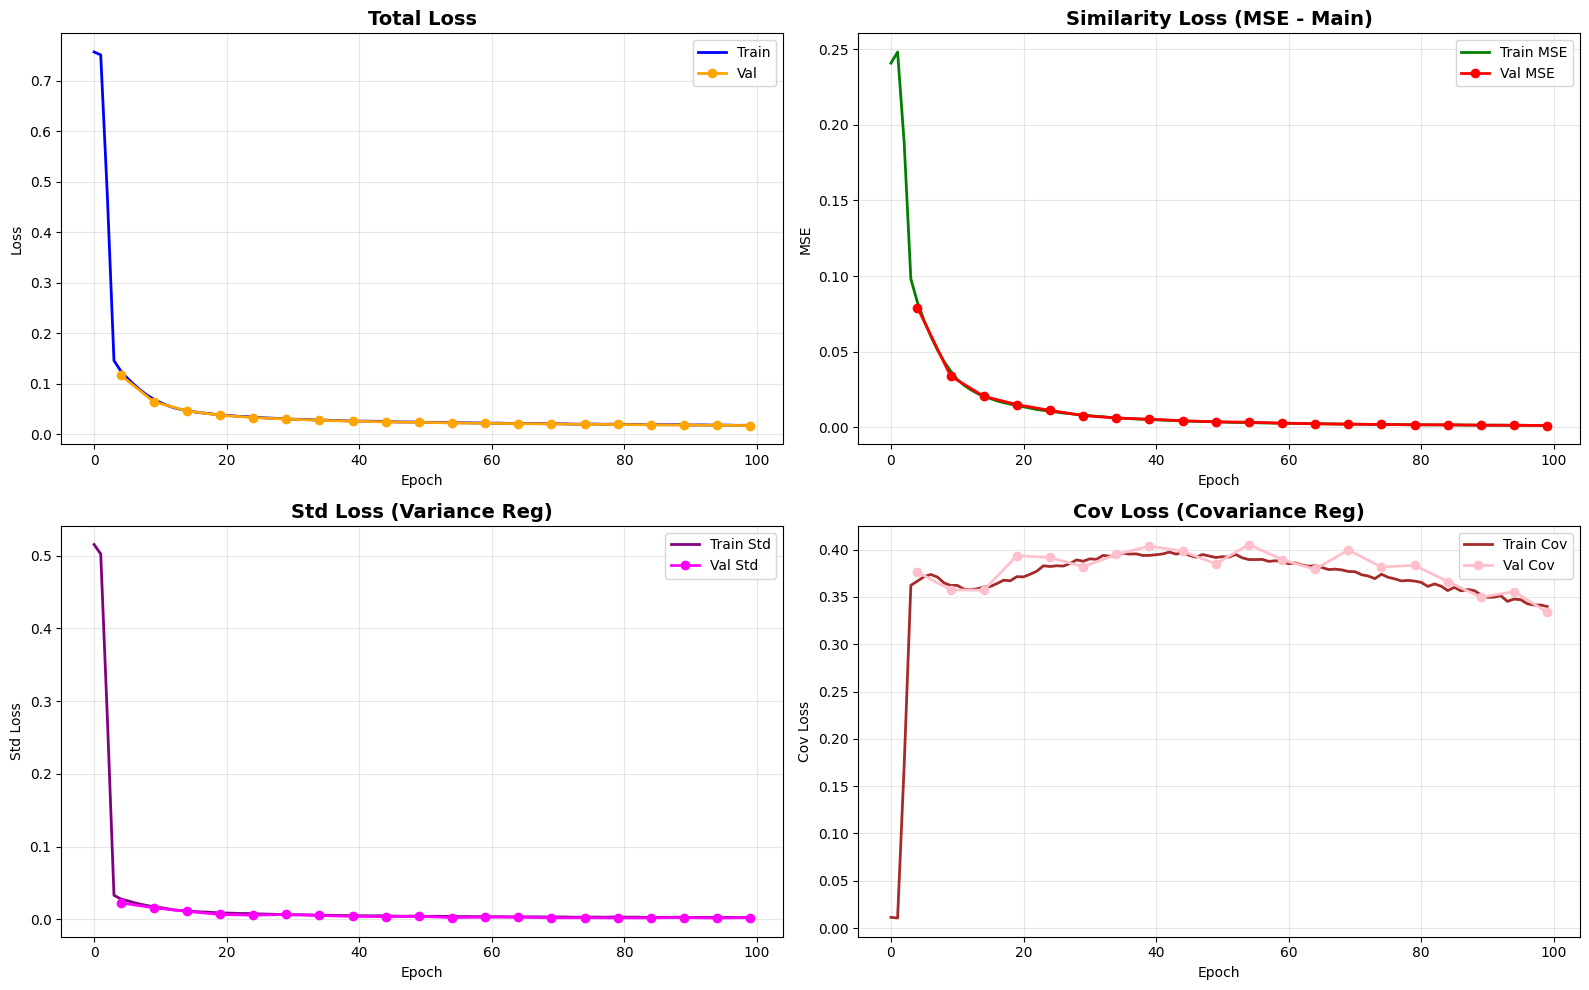


TRAINING SUMMARY
Prediction (MSE): 0.2407 → 0.0013 (↓ 0.2394)
Std Loss:        0.5153 → 0.0025
Cov Loss:        0.0114 → 0.3399
Total Loss:      0.7564 → 0.0174
✓ Model is learning! Prediction loss decreased significantly.


In [23]:
# ============================================================================
# Visualize Training Results
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
val_epochs = list(range(4, len(history['train_loss']), 5)) if history['val_loss'] else []

# Total Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, color='blue')
if history['val_loss']:
    axes[0, 0].plot(val_epochs, history['val_loss'], 'o-', label='Val', linewidth=2, markersize=6, color='orange')
axes[0, 0].set_title('Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Similarity Loss (MSE) - Main prediction loss
axes[0, 1].plot(history['train_sim'], label='Train MSE', linewidth=2, color='green')
if history['val_sim']:
    axes[0, 1].plot(val_epochs, history['val_sim'], 'o-', label='Val MSE', linewidth=2, markersize=6, color='red')
axes[0, 1].set_title('Similarity Loss (MSE - Main)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Std Loss - Variance regularization
axes[1, 0].plot(history['train_std'], label='Train Std', linewidth=2, color='purple')
if history['val_std']:
    axes[1, 0].plot(val_epochs, history['val_std'], 'o-', label='Val Std', linewidth=2, markersize=6, color='magenta')
axes[1, 0].set_title('Std Loss (Variance Reg)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Std Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cov Loss - Covariance regularization
axes[1, 1].plot(history['train_cov'], label='Train Cov', linewidth=2, color='brown')
if history['val_cov']:
    axes[1, 1].plot(val_epochs, history['val_cov'], 'o-', label='Val Cov', linewidth=2, markersize=6, color='pink')
axes[1, 1].set_title('Cov Loss (Covariance Reg)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Cov Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if model learned
final_sim = history['train_sim'][-1]
initial_sim = history['train_sim'][0]
improvement = initial_sim - final_sim

print(f"\n{'='*60}")
print(f"TRAINING SUMMARY")
print(f"{'='*60}")
print(f"Prediction (MSE): {initial_sim:.4f} → {final_sim:.4f} (↓ {improvement:.4f})")
print(f"Std Loss:        {history['train_std'][0]:.4f} → {history['train_std'][-1]:.4f}")
print(f"Cov Loss:        {history['train_cov'][0]:.4f} → {history['train_cov'][-1]:.4f}")
print(f"Total Loss:      {history['train_loss'][0]:.4f} → {history['train_loss'][-1]:.4f}")
print(f"{'='*60}")

if improvement > 0.05:
    print("✓ Model is learning! Prediction loss decreased significantly.")
else:
    print("❌ Warning: Prediction loss didn't decrease much.")


Visualizing latent space...


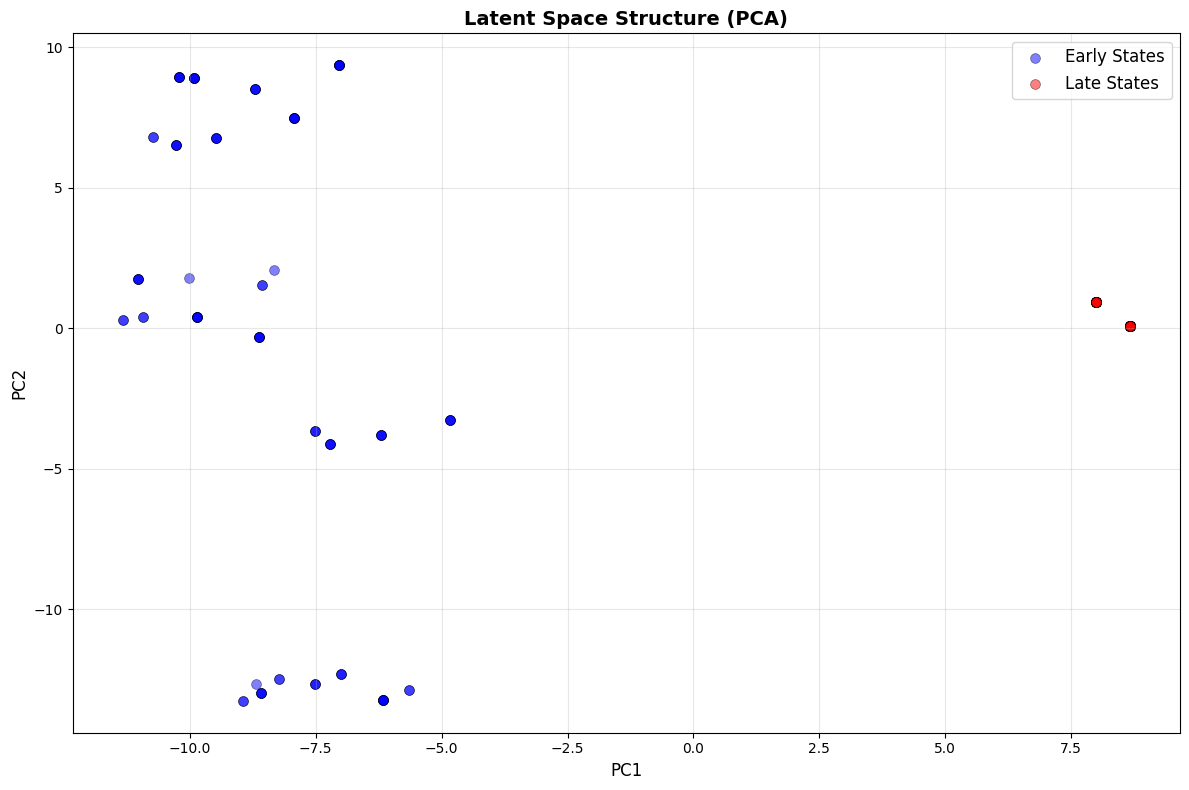


Explained variance: PC1=0.490, PC2=0.232
Average distance between early/late: 20.8510


In [24]:
# ============================================================================
# Latent Space Visualization (PCA)
# ============================================================================

from sklearn.decomposition import PCA

def visualize_latent_space(model, trajectories):
    """Visualize how well the model separates early vs late states"""
    latents = []
    labels = []  # 0: early, 1: late
    
    model.eval()
    with torch.no_grad():
        for traj in trajectories[:100]:
            if len(traj) < 5:
                continue
            
            # Early state
            early_obs = traj[0]['obs']
            early_tensor = torch.FloatTensor(early_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
            z_early = model.encode(early_tensor.to(device)).squeeze(0).cpu().numpy()
            latents.append(z_early)
            labels.append(0)
            
            # Late state
            late_idx = min(len(traj) - 1, 20)
            late_obs = traj[late_idx]['obs']
            late_tensor = torch.FloatTensor(late_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
            z_late = model.encode(late_tensor.to(device)).squeeze(0).cpu().numpy()
            latents.append(z_late)
            labels.append(1)
    
    latents = np.array(latents)
    labels = np.array(labels)
    
    # PCA to 2D
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['blue', 'red']
    labels_text = ['Early States', 'Late States']
    
    for i in range(2):
        mask = labels == i
        ax.scatter(latents_2d[mask, 0], latents_2d[mask, 1],
                   c=colors[i], label=labels_text[i], alpha=0.5, s=50,
                   edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_title('Latent Space Structure (PCA)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nExplained variance: PC1={pca.explained_variance_ratio_[0]:.3f}, "
          f"PC2={pca.explained_variance_ratio_[1]:.3f}")
    
    # Check separation
    from scipy.spatial.distance import cdist
    early_latents = latents[labels == 0]
    late_latents = latents[labels == 1]
    distances = cdist(early_latents, late_latents, 'euclidean')
    print(f"Average distance between early/late: {distances.mean():.4f}")

# Run visualization
print("Visualizing latent space...")
visualize_latent_space(model, trajectories)


In [3]:
# ============================================================================
# CEM Planner for Latent Space Planning
# ============================================================================

class CEMPlanner:
    """Cross-Entropy Method planner - optimizes action sequences in latent space"""
    def __init__(self, model, action_dim=7, horizon=15, 
                 num_iterations=10, num_samples=500, num_elites=50):
        self.model = model
        self.action_dim = action_dim
        self.horizon = horizon
        self.num_iterations = num_iterations
        self.num_samples = num_samples
        self.num_elites = num_elites
    
    @torch.no_grad()
    def plan(self, z_current, z_goal, verbose=False):
        device = z_current.device
        action_probs = torch.ones(self.horizon, self.action_dim, device=device) / self.action_dim
        best_cost = float('inf')
        best_actions = None
        
        for iteration in range(self.num_iterations):
            action_sequences = torch.multinomial(
                action_probs.repeat(self.num_samples, 1, 1).view(-1, self.action_dim),
                num_samples=1
            ).view(self.num_samples, self.horizon)
            
            costs = self._evaluate_sequences(z_current, z_goal, action_sequences)
            elite_indices = torch.argsort(costs)[:self.num_elites]
            elite_actions = action_sequences[elite_indices]
            
            action_probs = torch.zeros_like(action_probs)
            for h in range(self.horizon):
                for a in range(self.action_dim):
                    action_probs[h, a] = (elite_actions[:, h] == a).float().mean()
            
            action_probs = 0.9 * action_probs + 0.1 / self.action_dim
            
            if costs[elite_indices[0]] < best_cost:
                best_cost = costs[elite_indices[0]]
                best_actions = elite_actions[0].clone()
            
            if verbose:
                print(f"  Iter {iteration+1}: cost={best_cost:.4f}")
        
        return best_actions
    
    def _evaluate_sequences(self, z_current, z_goal, action_sequences):
        batch_size = action_sequences.shape[0]
        z = z_current.unsqueeze(0).expand(batch_size, -1)
        total_cost = torch.zeros(batch_size, device=z.device)
        
        for t in range(self.horizon):
            actions = action_sequences[:, t]
            z = self.model.predict_step(z, actions)
            cost = torch.norm(z - z_goal.unsqueeze(0), dim=1)
            total_cost += cost
        
        return total_cost

print("✓ CEM Planner defined")


✓ CEM Planner defined


In [ ]:
# ============================================================================
# Evaluate Planning in Real Environment
# ============================================================================
'''
from sklearn.utils.validation import _num_samples


def evaluate_planning(model, planner, env_name="MiniGrid-DoorKey-5x5-v0", num_episodes=10):
    """Test planning: hindsight goals (start → end of a trajectory)"""
    model.eval()
    successes = []
    
    for ep in range(num_episodes):
        # Use existing trajectory
        if ep >= len(trajectories):
            break
        traj = trajectories[ep]
        if len(traj) < 5:
            continue
        
        # Start and goal from trajectory
        start_obs = traj[0]['obs']
        goal_obs = traj[-1]['obs']
        
        # Encode
        start_tensor = torch.FloatTensor(start_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
        goal_tensor = torch.FloatTensor(goal_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
        
        with torch.no_grad():
            z_start = model.encode(start_tensor.to(device)).squeeze(0)
            z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
        
        # Plan
        print(f"\nEpisode {ep+1}: Planning...")
        actions_planned = planner.plan(z_start, z_goal, verbose=False)
        
        # Execute in real environment
        env = make_env(env_name)
        env.reset(seed=ep)
        
        total_reward = 0
        for t, action_idx in enumerate(actions_planned.cpu().numpy()):
            obs, reward, done, truncated, _ = env.step(int(action_idx))
            total_reward += reward
            if done:
                successes.append(1)
                print(f"  ✓ Success in {t+1} steps!")
                break
        else:
            successes.append(0)
            print(f"  ✗ Failed (didn't reach goal)")
        
        env.close()
    
    success_rate = np.mean(successes) if successes else 0
    print(f"\n{'='*50}")
    print(f"Success Rate: {success_rate*100:.1f}% ({sum(successes)}/{len(successes)})")
    print(f"{'='*50}")
    
    return success_rate

# Create planner and evaluate
planner = CEMPlanner(model, action_dim=7, horizon=15, num_iterations=15)
print("Evaluating planning with hindsight goals...")
success_rate = evaluate_planning(model, planner, num_episodes=10)
'''

In [27]:
# ============================================================================
# Test Real Execution with Replanning
# ============================================================================

def test_real_execution(model, planner, traj_idx=0, max_steps=30):
    """Execute planned actions in REAL environment with replanning"""
    traj = trajectories[traj_idx]
    goal_obs = traj[-1]['obs']
    
    # Create environment
    env = make_env("MiniGrid-DoorKey-5x5-v0")
    env.reset(seed=traj_idx)
    
    goal_tensor = torch.FloatTensor(goal_obs).permute(2,0,1).unsqueeze(0) / 255.0
    z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
    
    print(f"\n{'='*60}")
    print(f"REAL ENVIRONMENT EXECUTION TEST")
    print(f"{'='*60}")
    
    for step in range(max_steps):
        # Get current state from REAL environment
        current_obs = get_full_obs(env)
        current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
        
        with torch.no_grad():
            z_current = model.encode(current_tensor.to(device)).squeeze(0)
            distance = torch.norm(z_current - z_goal).item()
        
        print(f"Step {step}: Distance to goal = {distance:.4f}")
        
        if distance < 1.0:  # Close enough?
            print(f"✓ Reached goal region!")
            return True
        
        # Plan
        with torch.no_grad():
            actions = planner.plan(z_current, z_goal, verbose=False)
        
        # Execute FIRST action only
        action = int(actions[0].cpu().numpy())
        print(f"  → Executing action {action}")
        
        obs, reward, done, truncated, _ = env.step(action)
        
        if done:
            print(f"✓ TASK COMPLETED in {step+1} steps!")
            env.close()
            return True
    
    print(f"✗ Failed to reach goal in {max_steps} steps")
    env.close()
    return False

# Test with better planner
planner_new = CEMPlanner(
    model, 
    horizon=8, 
    num_iterations=15,
    num_samples=1000,
    num_elites=100
)

success = test_real_execution(model, planner_new, traj_idx=0, max_steps=30)


REAL ENVIRONMENT EXECUTION TEST
Step 0: Distance to goal = 21.3838
  → Executing action 1
Step 1: Distance to goal = 20.5519
  → Executing action 3
Step 2: Distance to goal = 18.2262
  → Executing action 2
Step 3: Distance to goal = 17.6846
  → Executing action 2
Step 4: Distance to goal = 20.5805
  → Executing action 1
Step 5: Distance to goal = 18.6225
  → Executing action 5
Step 6: Distance to goal = 13.3324
  → Executing action 2
Step 7: Distance to goal = 11.1892
  → Executing action 2
Step 8: Distance to goal = 12.4920
  → Executing action 1
Step 9: Distance to goal = 12.7740
  → Executing action 2
Step 10: Distance to goal = 11.6320
  → Executing action 2
✓ TASK COMPLETED in 11 steps!



Visualizing planning for trajectory 0...
Planning...
  Iter 1: cost=202.0837
  Iter 2: cost=175.4250
  Iter 3: cost=175.4250
  Iter 4: cost=175.4250
  Iter 5: cost=175.4250
  Iter 6: cost=175.4250
  Iter 7: cost=175.4250
  Iter 8: cost=175.4250
  Iter 9: cost=175.4250
  Iter 10: cost=175.4250
  Iter 11: cost=175.4250
  Iter 12: cost=175.4250
  Iter 13: cost=175.4250
  Iter 14: cost=175.4250
  Iter 15: cost=175.4250


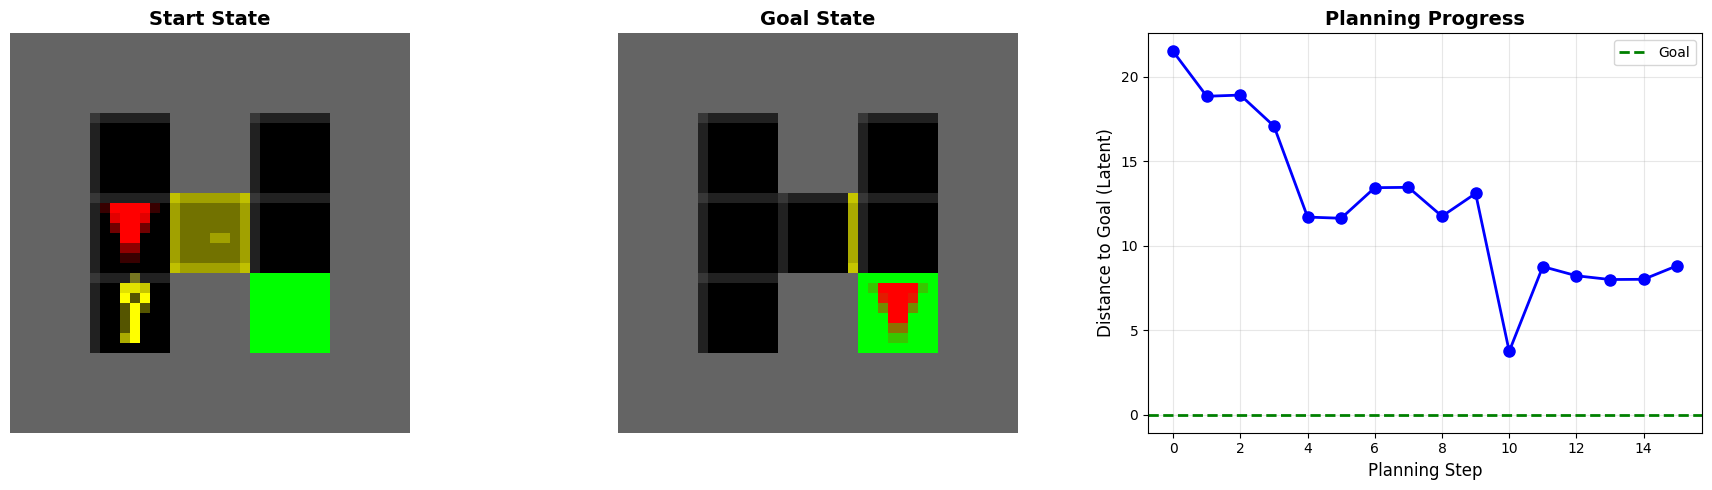


Planned actions: [3 6 0 5 6 2 6 2 1 2 4 5 0 5 0]
Initial distance: 21.4976
Final distance: 8.8164
Improvement: 12.6812


In [28]:
# ============================================================================
# Visualize Single Planning Episode
# ============================================================================

def visualize_planning_episode(model, planner, trajectory_idx=0):
    """Detailed visualization of one planning episode"""
    traj = trajectories[trajectory_idx]
    
    start_obs = traj[0]['obs']
    goal_obs = traj[-1]['obs']
    
    # Encode
    start_tensor = torch.FloatTensor(start_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
    goal_tensor = torch.FloatTensor(goal_obs).permute(2, 0, 1).unsqueeze(0) / 255.0
    
    with torch.no_grad():
        z_start = model.encode(start_tensor.to(device)).squeeze(0)
        z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
    
    # Plan
    print("Planning...")
    action_sequence = planner.plan(z_start, z_goal, verbose=True)
    
    # Roll out latent trajectory
    latent_trajectory = [z_start.cpu().numpy()]
    with torch.no_grad():
        z_current = z_start
        for action in action_sequence:
            z_current = model.predict_step(z_current.unsqueeze(0), action.unsqueeze(0)).squeeze(0)
            latent_trajectory.append(z_current.cpu().numpy())
    
    latent_trajectory = np.array(latent_trajectory)
    z_goal_np = z_goal.cpu().numpy()
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].imshow(start_obs)
    axes[0].set_title('Start State', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(goal_obs)
    axes[1].set_title('Goal State', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    distances = [np.linalg.norm(z - z_goal_np) for z in latent_trajectory]
    axes[2].plot(distances, marker='o', linewidth=2, markersize=8, color='blue')
    axes[2].set_xlabel('Planning Step', fontsize=12)
    axes[2].set_ylabel('Distance to Goal (Latent)', fontsize=12)
    axes[2].set_title('Planning Progress', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='green', linestyle='--', label='Goal', linewidth=2)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPlanned actions: {action_sequence.cpu().numpy()}")
    print(f"Initial distance: {distances[0]:.4f}")
    print(f"Final distance: {distances[-1]:.4f}")
    print(f"Improvement: {distances[0] - distances[-1]:.4f}")

# Visualize one episode
print("\nVisualizing planning for trajectory 0...")
visualize_planning_episode(model, planner, trajectory_idx=0)


100%|██████████| 50/50 [00:00<00:00, 389.93it/s]


0it [00:00, ?it/s]


✓ Collected 50 trajectories
  Total transitions: 541
  Avg trajectory length: 10.8
FIXED version - captures EVERY step!



Episode 1: ✓ Completed in 11 steps!

📹 Episode 1 - 12 steps...


/var/folders/pn/1xb8skrs7jx5wqhyh9tdxm5r0000gn/T/ipykernel_24494/4225547633.py:128: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/apurva/Downloads/jepa/jepa_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


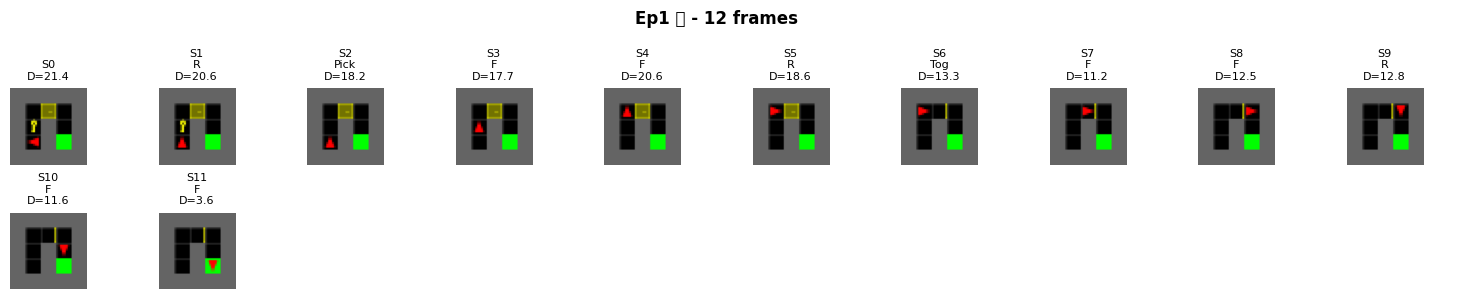

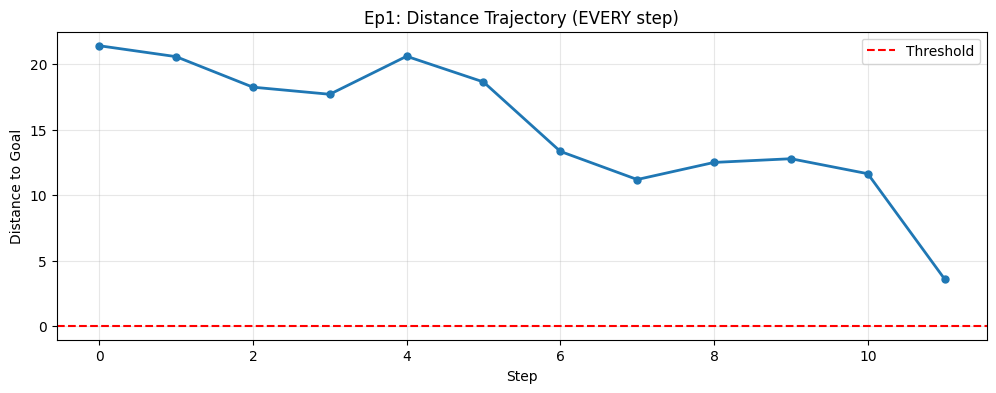


Episode 2: ✓ Completed in 13 steps!

📹 Episode 2 - 14 steps...


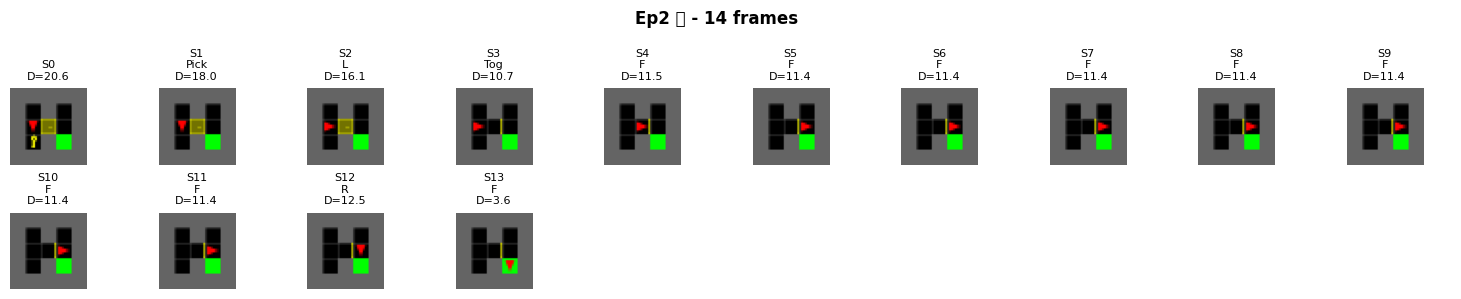

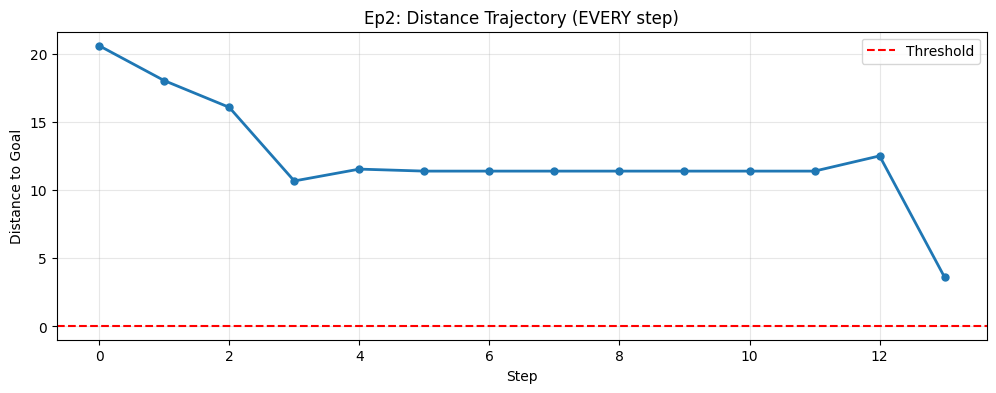


Episode 3: ✓ Completed in 13 steps!

📹 Episode 3 - 14 steps...


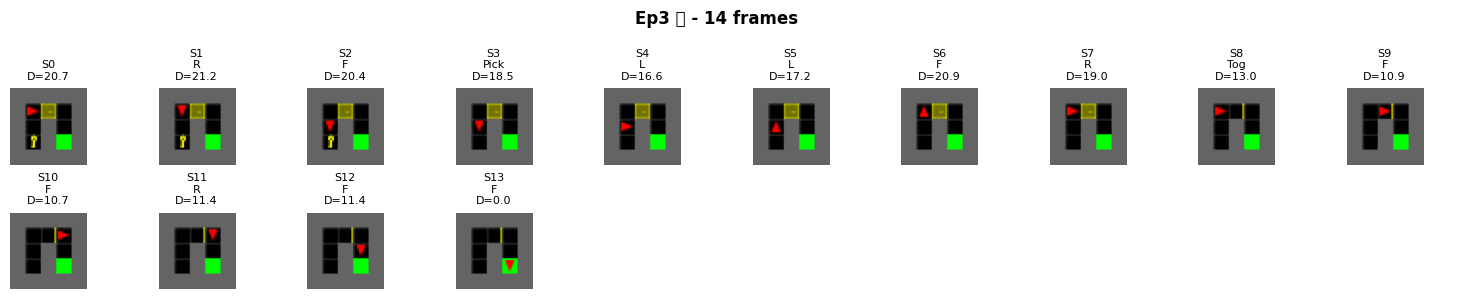

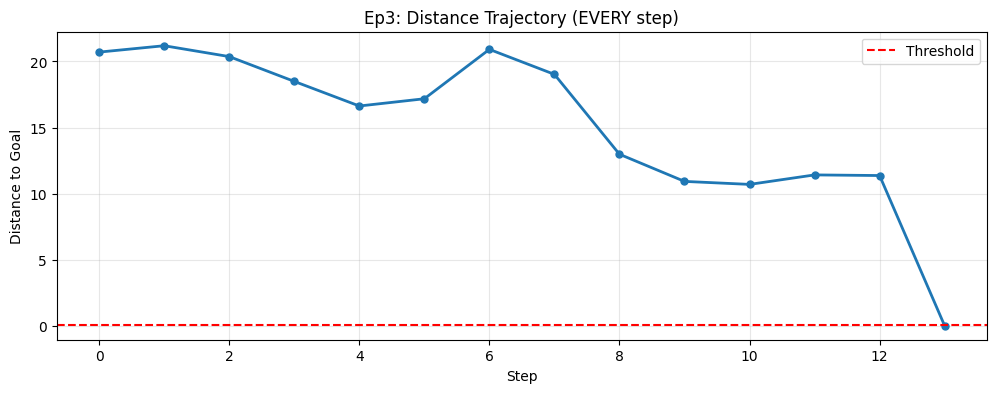



RESULTS (FIXED - every step captured)
Success: 100.0% (3/3)
Avg Steps: 12.3


In [29]:
# ============================================================================
# FIXED: Capture EVERY Step (not just every replan_every-th step)
# ============================================================================

eval_trajectories = collect_dataset(
    env_name="MiniGrid-DoorKey-5x5-v0",
    num_trajectories=50,  # Start small for testing
    bfs_ratio=1.00,  # All BFS trajectories
    max_steps=100
)

def evaluate_with_replanning_fixed(model, planner, num_episodes=10, max_steps=30, replan_every=1, visualize=True):
    """Evaluate planning and visualize EVERY single step"""
    successes = []
    steps_to_goal = []
    
    for ep in range(num_episodes):
        if ep >= len(eval_trajectories):
            break
        
        traj = eval_trajectories[ep]
        goal_obs = traj[-1]['obs']
        
        env = make_env("MiniGrid-DoorKey-5x5-v0")
        env.reset(seed=ep)
        
        goal_tensor = torch.FloatTensor(goal_obs).permute(2,0,1).unsqueeze(0) / 255.0
        z_goal = model.encode(goal_tensor.to(device)).squeeze(0)

        episode_images = []
        episode_distances = []
        episode_actions = []
        
        # Save initial state
        current_obs = get_full_obs(env)
        episode_images.append(current_obs.copy())
        current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
        with torch.no_grad():
            z_current = model.encode(current_tensor.to(device)).squeeze(0)
            distance = torch.norm(z_current - z_goal).item()
            episode_distances.append(distance)
        
        total_steps = 0
        done = False
        
        while total_steps < max_steps and not done:
            current_obs = get_full_obs(env)
            current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
            
            with torch.no_grad():
                z_current = model.encode(current_tensor.to(device)).squeeze(0)
                distance = torch.norm(z_current - z_goal).item()
            
            #if distance < 0.05:
            #    successes.append(1)
            #    steps_to_goal.append(total_steps)
            #    print(f"Episode {ep+1}: ✓ Success in {total_steps} steps (dist={distance:.4f})")
            #    break
            
            with torch.no_grad():
                actions = planner.plan(z_current, z_goal, verbose=False)
            
            for a_idx in range(min(replan_every, len(actions))):
                action = int(actions[a_idx].cpu().numpy())
                obs, reward, done, truncated, _ = env.step(action)
                total_steps += 1
                
                # Save AFTER action
                new_obs = get_full_obs(env)
                episode_images.append(new_obs.copy())
                episode_actions.append(action)
                
                new_tensor = torch.FloatTensor(new_obs).permute(2,0,1).unsqueeze(0) / 255.0
                with torch.no_grad():
                    z_new = model.encode(new_tensor.to(device)).squeeze(0)
                    new_distance = torch.norm(z_new - z_goal).item()
                    episode_distances.append(new_distance)
                
                if done:
                    successes.append(1)
                    steps_to_goal.append(total_steps)
                    print(f"Episode {ep+1}: ✓ Completed in {total_steps} steps!")
                    break
                
                if total_steps >= max_steps:
                    break
        
        if not done and distance >= 0.05:
            successes.append(0)
            print(f"Episode {ep+1}: ✗ Failed")
        
        env.close()
        
        # Visualize
        if visualize and len(episode_images) > 1:
            print(f"\n📹 Episode {ep+1} - {len(episode_images)} steps...")
            
            num_images = len(episode_images)
            cols = min(10, num_images)
            rows = (num_images + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
            if rows == 1 and cols == 1:
                axes = np.array([[axes]])
            elif rows == 1:
                axes = axes.reshape(1, -1)
            elif cols == 1:
                axes = axes.reshape(-1, 1)
            
            action_names = ['L', 'R', 'F', 'Pick', 'Drop', 'Tog', 'Done']
            
            for idx in range(min(num_images, rows * cols)):
                row, col = idx // cols, idx % cols
                axes[row, col].imshow(episode_images[idx])
                if idx == 0:
                    title = f'S0\nD={episode_distances[idx]:.1f}'
                else:
                    title = f'S{idx}\n{action_names[episode_actions[idx-1]]}\nD={episode_distances[idx]:.1f}'
                axes[row, col].set_title(title, fontsize=8)
                axes[row, col].axis('off')
            
            for idx in range(num_images, rows * cols):
                row, col = idx // cols, idx % cols
                axes[row, col].axis('off')
            
            success_str = "✅" if ep < len(successes) and successes[ep] == 1 else "❌"
            fig.suptitle(f'Ep{ep+1} {success_str} - {len(episode_images)} frames', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Distance plot
            plt.figure(figsize=(12, 4))
            plt.plot(episode_distances, 'o-', linewidth=2, markersize=5)
            plt.axhline(0.05, color='red', linestyle='--', label='Threshold')
            plt.xlabel('Step')
            plt.ylabel('Distance to Goal')
            plt.title(f'Ep{ep+1}: Distance Trajectory (EVERY step)')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
            print()
    
    success_rate = np.mean(successes)
    avg_steps = np.mean(steps_to_goal) if steps_to_goal else 0
    
    print(f"\n{'='*60}")
    print(f"RESULTS (FIXED - every step captured)")
    print(f"{'='*60}")
    print(f"Success: {success_rate*100:.1f}% ({sum(successes)}/{len(successes)})")
    print(f"Avg Steps: {avg_steps:.1f}")
    print(f"{'='*60}")
    
    return success_rate, avg_steps

print("FIXED version - captures EVERY step!\n")
success_rate, avg_steps = evaluate_with_replanning_fixed(model, planner, num_episodes=3, replan_every=1, visualize=True)


Episode 1: ✓ Completed in 12 steps!
Episode 2: ✓ Completed in 20 steps!
Episode 3: ✓ Completed in 18 steps!
Episode 4: ✓ Completed in 13 steps!
Episode 5: ✓ Completed in 26 steps!
Episode 6: ✓ Completed in 12 steps!
Episode 7: ✓ Completed in 15 steps!
Episode 8: ✗ Failed
Episode 9: ✓ Completed in 14 steps!
Episode 10: ✗ Failed
Episode 11: ✓ Completed in 14 steps!
Episode 12: ✓ Completed in 17 steps!
Episode 13: ✗ Failed
Episode 14: ✓ Completed in 15 steps!
Episode 15: ✓ Completed in 12 steps!
Episode 16: ✓ Completed in 14 steps!
Episode 17: ✓ Completed in 9 steps!
Episode 18: ✓ Completed in 10 steps!
Episode 19: ✓ Completed in 10 steps!
Episode 20: ✓ Completed in 25 steps!
Episode 21: ✓ Completed in 13 steps!
Episode 22: ✓ Completed in 12 steps!
Episode 23: ✓ Completed in 10 steps!
Episode 24: ✓ Completed in 12 steps!
Episode 25: ✓ Completed in 26 steps!
Episode 26: ✓ Completed in 16 steps!
Episode 27: ✓ Completed in 13 steps!
Episode 28: ✓ Completed in 21 steps!
Episode 29: ✓ Complete

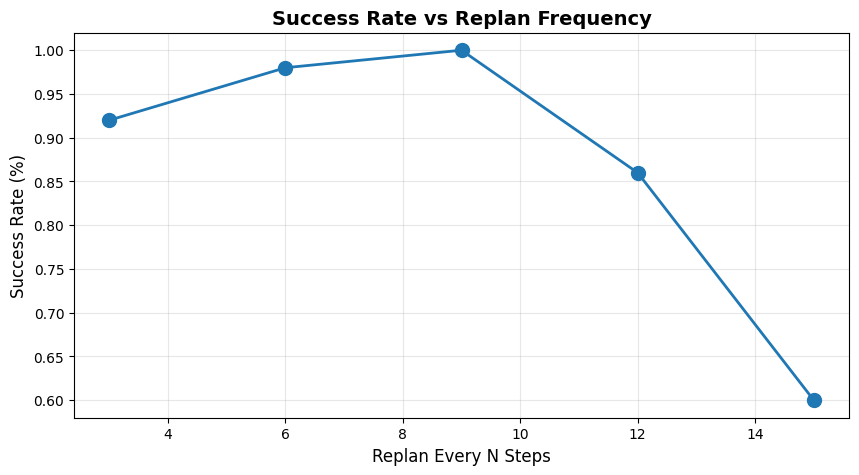

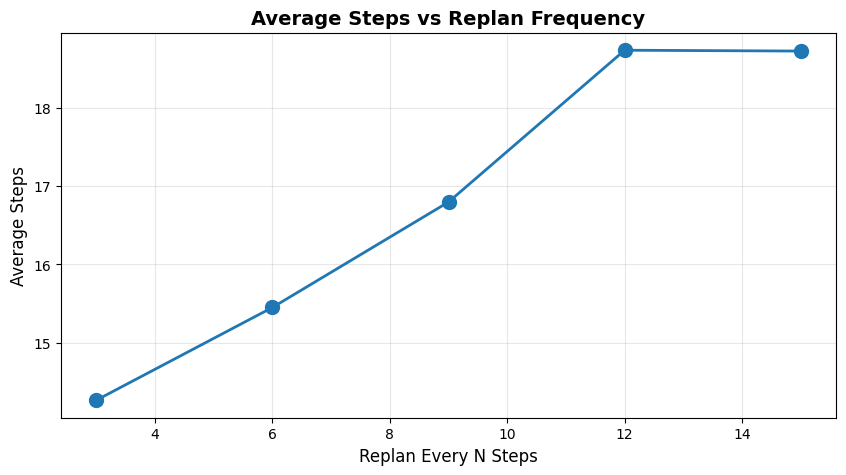

In [32]:
success_rates_list, avg_steps_list = [], []
replan_values = list(range(3, 16, 3))
for replan_every in replan_values:
    success_rate, avg_steps = evaluate_with_replanning_fixed(model, planner, num_episodes=50, replan_every=replan_every, visualize=False)
    success_rates_list.append(success_rate)
    avg_steps_list.append(avg_steps)

# --- Plot 1: Success Rate ---
plt.figure(figsize=(10, 5))
plt.plot(replan_values, success_rates_list, 'o-', linewidth=2, markersize=10)
plt.xlabel('Replan Every N Steps', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Success Rate vs Replan Frequency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Average Steps ---
plt.figure(figsize=(10, 5))
plt.plot(replan_values, avg_steps_list, 'o-', linewidth=2, markersize=10)
plt.xlabel('Replan Every N Steps', fontsize=12)
plt.ylabel('Average Steps', fontsize=12)
plt.title('Average Steps vs Replan Frequency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


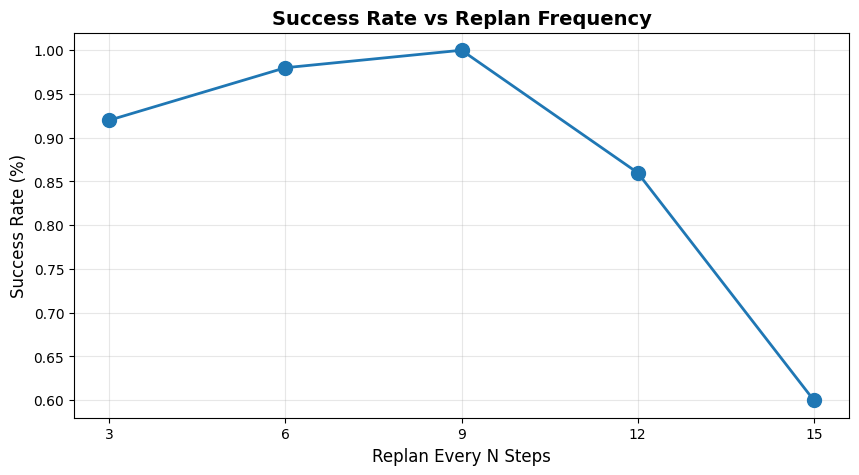

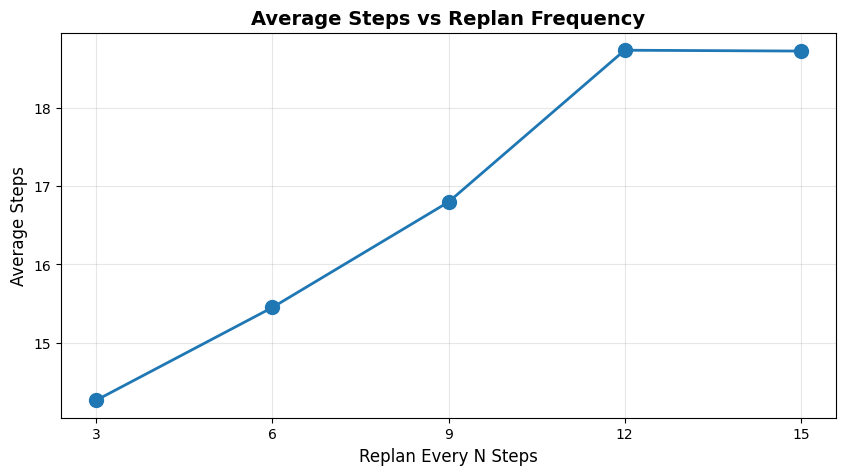

In [34]:
# --- Plot 1: Success Rate ---
plt.figure(figsize=(10, 5))
plt.plot(replan_values, success_rates_list, 'o-', linewidth=2, markersize=10)
plt.xlabel('Replan Every N Steps', fontsize=12)
plt.xticks(replan_values)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Success Rate vs Replan Frequency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Average Steps ---
plt.figure(figsize=(10, 5))
plt.plot(replan_values, avg_steps_list, 'o-', linewidth=2, markersize=10)
plt.xlabel('Replan Every N Steps', fontsize=12)
plt.xticks(replan_values)
plt.ylabel('Average Steps', fontsize=12)
plt.title('Average Steps vs Replan Frequency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


In [35]:
with open("success_rates_list.txt", "w") as f:
    for item in success_rates_list:
        f.write(f"{item}\n")

with open("avg_steps_list.txt", "w") as f:
    for item in avg_steps_list:
        f.write(f"{item}\n")

Testing generalization on simpler task...

Testing on: MiniGrid-Empty-5x5-v0
(Model trained on: MiniGrid-DoorKey-5x5-v0)
Difference: No door, no key - just navigate!

  Seed 0: 6 steps
  Seed 1: 6 steps
  Seed 2: 6 steps
  Seed 3: 6 steps
  Seed 4: 6 steps
  Seed 5: 6 steps
  Seed 6: 6 steps
  Seed 7: 6 steps
  Seed 8: 6 steps
  Seed 9: 6 steps
  Seed 10: 6 steps
  Seed 11: 6 steps
  Seed 12: 6 steps
  Seed 13: 6 steps
  Seed 14: 6 steps
  Seed 15: 6 steps
  Seed 16: 6 steps
  Seed 17: 6 steps
  Seed 18: 6 steps
  Seed 19: 6 steps
  Seed 20: 6 steps
  Seed 21: 6 steps
  Seed 22: 6 steps
  Seed 23: 6 steps
  Seed 24: 6 steps
  Seed 25: 6 steps
  Seed 26: 6 steps
  Seed 27: 6 steps
  Seed 28: 6 steps
  Seed 29: 6 steps
  Seed 30: 6 steps
  Seed 31: 6 steps
  Seed 32: 6 steps
  Seed 33: 6 steps
  Seed 34: 6 steps
  Seed 35: 6 steps
  Seed 36: 6 steps
  Seed 37: 6 steps
  Seed 38: 6 steps
  Seed 39: 6 steps
  Seed 40: 6 steps
  Seed 41: 6 steps
  Seed 42: 6 steps
  Seed 43: 6 steps
  Seed 

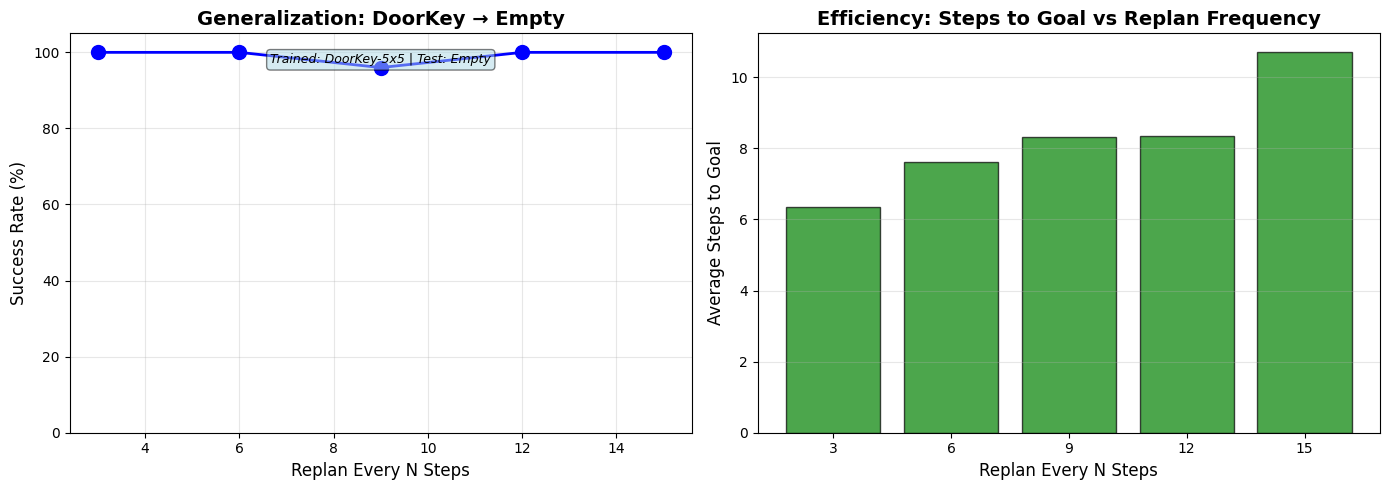

In [58]:
# ============================================================================
# Test Generalization: Simpler Environment (Empty-5x5)
# ============================================================================
import json
print("Testing generalization on simpler task...\n")

def test_replan_frequency(model, env_name="MiniGrid-Empty-5x5-v0", num_episodes=20, seed_offset=0):
    """
    Test how model generalizes to simpler task
    Empty-5x5: Same size, no door/key, just navigate to goal
    """
    
    print(f"Testing on: {env_name}")
    print(f"(Model trained on: MiniGrid-DoorKey-5x5-v0)")
    print(f"Difference: No door, no key - just navigate!\n")
    
    # Collect test trajectories from unseen seeds
    print(f"Collecting test trajectories...")
    test_trajectories = []
    for i in range(num_episodes):
        seed = seed_offset + i  # Use unseen seeds!
        actions = bfs_solve(env_name, seed)
        if actions:
            traj = collect_trajectory(env_name, seed, actions, max_steps=50)
            if traj:
                test_trajectories.append((seed, traj))  # Store seed too
                print(f"  Seed {seed}: {len(traj)} steps")
    
    print(f"\n✓ Collected {len(test_trajectories)} trajectories")
    mean_len = np.mean([len(t) for seed, t in test_trajectories])
    print(f"  Mean length: {mean_len:.1f} steps")
    print(f"  Max length: {max([len(t) for seed, t in test_trajectories])} steps")
    print(f"  Note: Empty-5x5 is simpler (shorter) than DoorKey-5x5!\n")
    
    # Test different replan frequencies (Empty-5x5 episodes are shorter ~5-8 steps)
    replan_frequencies = list(range(3, 16, 3))
    results = {}
    
    for replan_freq in replan_frequencies:
        print(f"{'='*60}")
        print(f"Testing replan_every={replan_freq}")
        print(f"{'='*60}")
        
        successes = []
        steps_taken = []
        
        for ep, (seed, traj) in enumerate(test_trajectories[:num_episodes]):
            goal_obs = traj[-1]['obs']
            goal_tensor = torch.FloatTensor(goal_obs).permute(2,0,1).unsqueeze(0) / 255.0
            z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
            
            env = make_env(env_name)
            env.reset(seed=seed)  # Use the actual seed from trajectory
            
            step = 0
            max_steps = 50  # Reasonable for 5x5
            success = False
            
            while step < max_steps:
                current_obs = get_full_obs(env)
                current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
                
                with torch.no_grad():
                    z_current = model.encode(current_tensor.to(device)).squeeze(0)
                    distance = torch.norm(z_current - z_goal).item()
                
                if distance < 1.0:
                    successes.append(1)
                    steps_taken.append(step)
                    print(f"  Episode {ep+1}: ✓ Success in {step} steps")
                    success = True
                    break
                
                # Plan
                with torch.no_grad():
                    actions = planner.plan(z_current, z_goal, verbose=False)
                
                # Execute replan_freq actions
                for i in range(min(replan_freq, len(actions), max_steps - step)):
                    action = int(actions[i].cpu().numpy())
                    obs, reward, done, truncated, _ = env.step(action)
                    step += 1
                    
                    if done:
                        successes.append(1)
                        steps_taken.append(step)
                        print(f"  Episode {ep+1}: ✓ Task completed in {step} steps!")
                        success = True
                        break
                
                if success or step >= max_steps:
                    break
            
            if not success:
                successes.append(0)
                print(f"  Episode {ep+1}: ✗ Failed")
            
            env.close()
        
        success_rate = np.mean(successes) * 100
        avg_steps = np.mean(steps_taken) if steps_taken else 0
        
        results[replan_freq] = {
            'success_rate': success_rate,
            'avg_steps': avg_steps,
            'num_successes': sum(successes)
        }
        
        print(f"\nResults: {success_rate:.1f}% success ({sum(successes)}/{len(successes)})")
        if steps_taken:
            print(f"Average steps: {avg_steps:.1f}\n")
    
    # Summary visualization
    print(f"\n{'='*60}")
    print(f"SUMMARY: Generalization Test")
    print(f"Environment: {env_name}")
    print(f"Trained on: DoorKey-5x5 → Testing on: Empty-5x5")
    print(f"{'='*60}")
    print(f"{'Replan Every':<15} {'Success Rate':<15} {'Avg Steps':<15}")
    print(f"{'-'*60}")
    for freq in replan_frequencies:
        r = results[freq]
        print(f"{freq:<15} {r['success_rate']:<15.1f}% {r['avg_steps']:<15.1f}")
    print(f"{'='*60}")
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    freqs = list(results.keys())
    success_rates = [results[f]['success_rate'] for f in freqs]
    avg_steps_list = [results[f]['avg_steps'] if results[f]['avg_steps'] > 0 else 0 for f in freqs]
    
    # Success rate vs replan frequency
    axes[0].plot(freqs, success_rates, 'o-', linewidth=2, markersize=10, color='blue')
    axes[0].set_xlabel('Replan Every N Steps', fontsize=12)
    axes[0].set_ylabel('Success Rate (%)', fontsize=12)
    axes[0].set_title('Generalization: DoorKey → '+env_name.split('MiniGrid-')[1].split('-5x5')[0], fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 105])
    # Add annotation
    axes[0].text(0.5, 0.95, 'Trained: DoorKey-5x5 | Test: ' + env_name.split('MiniGrid-')[1].split('-5x5')[0],
                transform=axes[0].transAxes, ha='center', va='top', 
                fontsize=9, style='italic', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # Average steps
    axes[1].bar(range(len(freqs)), avg_steps_list, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_xticks(range(len(freqs)))
    axes[1].set_xticklabels(freqs)
    axes[1].set_xlabel('Replan Every N Steps', fontsize=12)
    axes[1].set_ylabel('Average Steps to Goal', fontsize=12)
    axes[1].set_title('Efficiency: Steps to Goal vs Replan Frequency', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Test generalization: Empty-5x5 (no door, no key!)
results = test_replan_frequency(
    model, 
    env_name="MiniGrid-Empty-5x5-v0",  # Simpler task!
    num_episodes=50,
    seed_offset=0
)
with open("general_test_results.json", "w") as f:
    json.dump(results, f, indent=4)

Testing on: MiniGrid-Empty-Random-5x5-v0
(Model trained on: MiniGrid-DoorKey-5x5-v0)
Difference: No door, no key - just navigate!

  Seed 0: 5 steps
  Seed 1: 5 steps
  Seed 2: 4 steps
  Seed 3: 6 steps
  Seed 4: 3 steps
  Seed 5: 5 steps
  Seed 6: 5 steps
  Seed 7: 3 steps
  Seed 8: 4 steps
  Seed 9: 3 steps
  Seed 10: 7 steps
  Seed 11: 3 steps
  Seed 12: 5 steps
  Seed 13: 2 steps
  Seed 14: 4 steps
  Seed 15: 6 steps
  Seed 16: 5 steps
  Seed 17: 5 steps
  Seed 18: 4 steps
  Seed 19: 4 steps
  Seed 20: 6 steps
  Seed 21: 4 steps
  Seed 22: 4 steps
  Seed 23: 3 steps
  Seed 24: 7 steps
  Seed 25: 7 steps
  Seed 26: 5 steps
  Seed 27: 7 steps
  Seed 28: 6 steps
  Seed 29: 4 steps
  Seed 30: 2 steps
  Seed 31: 2 steps
  Seed 32: 5 steps
  Seed 33: 6 steps
  Seed 34: 3 steps
  Seed 35: 5 steps
  Seed 36: 5 steps
  Seed 37: 7 steps
  Seed 38: 5 steps
  Seed 39: 6 steps
  Seed 40: 2 steps
  Seed 41: 3 steps
  Seed 42: 2 steps
  Seed 43: 3 steps
  Seed 44: 3 steps
  Seed 45: 3 steps
  See

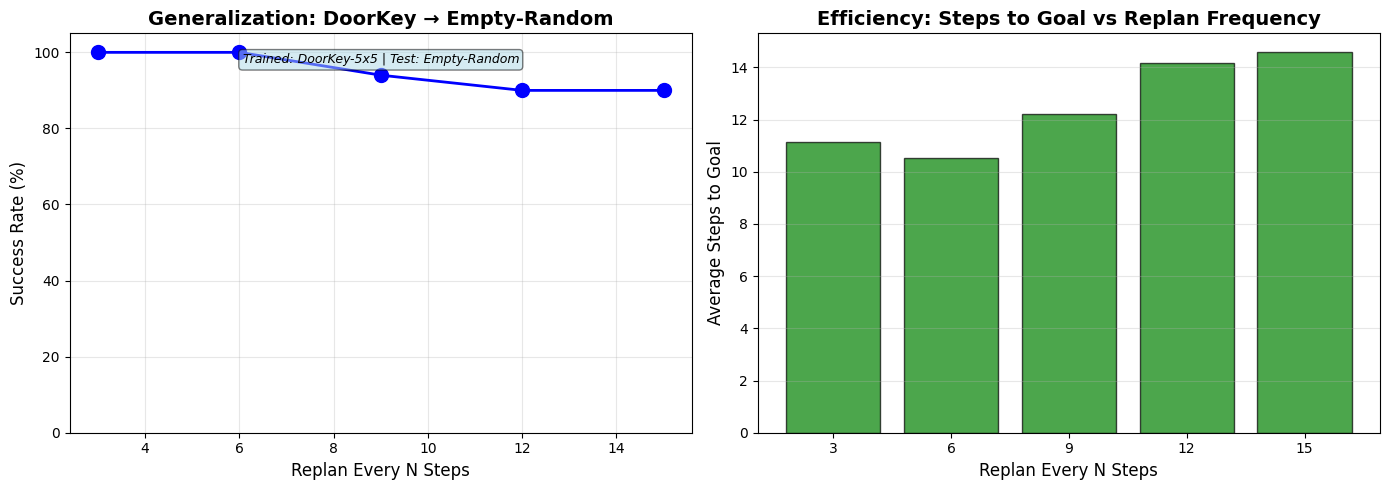

In [59]:
# Test generalization: Empty-5x5 (no door, no key!)
results2 = test_replan_frequency(
    model, 
    env_name="MiniGrid-Empty-Random-5x5-v0",  # Simpler task!
    num_episodes=50,
    seed_offset=0
)
with open("general_test_results2.json", "w") as f:
    json.dump(results2, f, indent=4)

Testing on: MiniGrid-Dynamic-Obstacles-5x5-v0
(Model trained on: MiniGrid-DoorKey-5x5-v0)
Difference: No door, no key - just navigate!

  Seed 0: 7 steps
  Seed 1: 3 steps
  Seed 2: 5 steps
  Seed 3: 6 steps
  Seed 4: 6 steps
  Seed 5: 3 steps
  Seed 6: 6 steps
  Seed 7: 8 steps
  Seed 8: 7 steps
  Seed 9: 5 steps
  Seed 12: 3 steps
  Seed 13: 4 steps
  Seed 14: 7 steps
  Seed 15: 3 steps
  Seed 16: 3 steps
  Seed 17: 7 steps
  Seed 18: 4 steps
  Seed 19: 6 steps
  Seed 20: 3 steps
  Seed 21: 5 steps
  Seed 22: 5 steps
  Seed 23: 3 steps
  Seed 24: 4 steps
  Seed 25: 3 steps
  Seed 26: 7 steps
  Seed 29: 3 steps
  Seed 30: 5 steps
  Seed 31: 5 steps
  Seed 32: 3 steps
  Seed 33: 5 steps
  Seed 34: 5 steps
  Seed 35: 4 steps
  Seed 36: 4 steps
  Seed 37: 3 steps
  Seed 38: 6 steps
  Seed 39: 7 steps
  Seed 41: 5 steps
  Seed 42: 6 steps
  Seed 43: 3 steps
  Seed 46: 3 steps
  Seed 47: 6 steps
  Seed 48: 4 steps
  Seed 49: 6 steps

✓ Collected 43 trajectories
  Mean length: 4.8 steps
  M

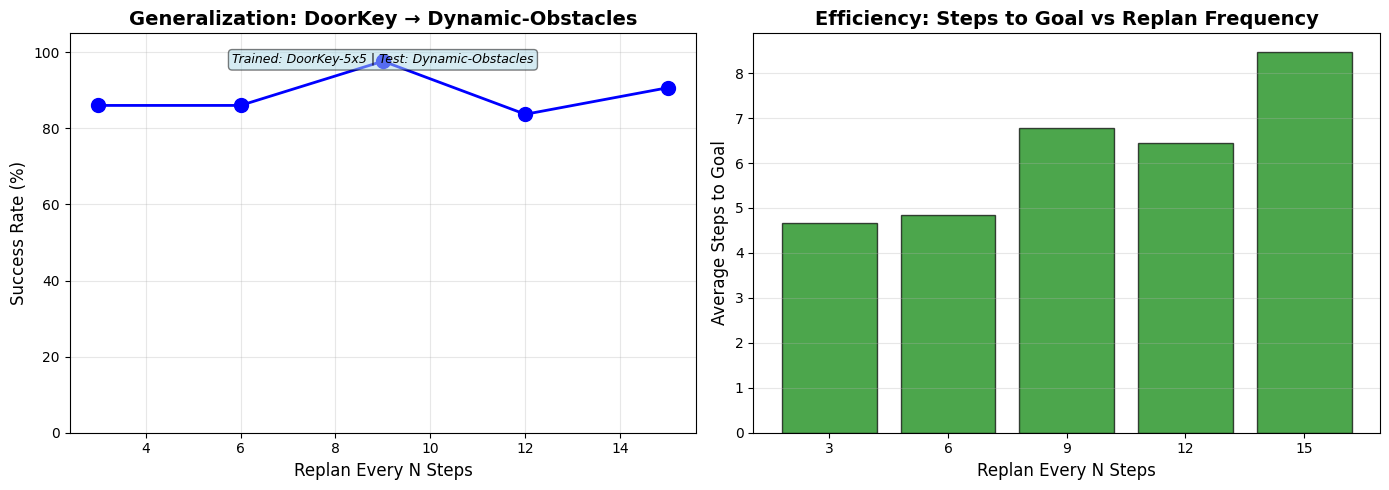

In [ ]:
# Test generalization: Empty-5x5 (no door, no key!)
results3 = test_replan_frequency(
    model, 
    env_name="MiniGrid-Dynamic-Obstacles-5x5-v0",  # Simpler task!
    num_episodes=50,
    seed_offset=0
)
with open("general_test_results3.json", "w") as f:
    json.dump(results3, f, indent=4)

Environment: MiniGrid-Empty-5x5-v0


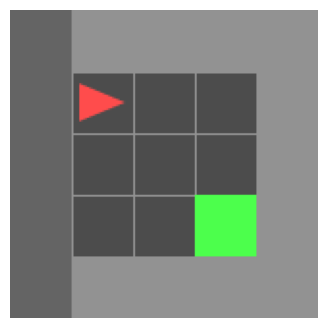

Environment: MiniGrid-Empty-Random-5x5-v0


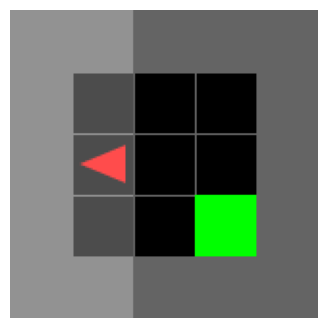

Environment: MiniGrid-Dynamic-Obstacles-5x5-v0


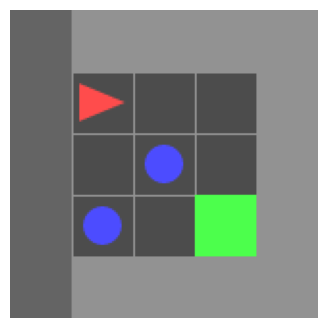

Environment: MiniGrid-DoorKey-5x5-v0


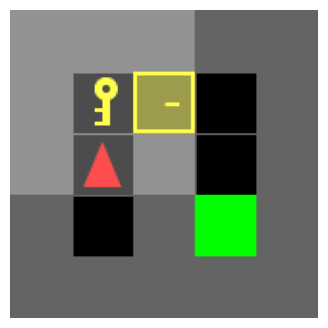

In [95]:
import matplotlib.pyplot as plt

# List of 5x5 MiniGrid environments
env_names = [
    "MiniGrid-Empty-5x5-v0",
    "MiniGrid-Empty-Random-5x5-v0",
    "MiniGrid-Dynamic-Obstacles-5x5-v0",
    "MiniGrid-DoorKey-5x5-v0",
]

for env_name in env_names:
    print(f"Environment: {env_name}")
    
    # Create env in RGB array mode (for inline visualization)
    env = gym.make(env_name, render_mode="rgb_array")
    
    # Reset environment to get initial observation
    obs = env.reset()
    
    # Render returns an RGB array
    frame = env.render()
    
    # Display the environment inline
    plt.figure(figsize=(4,4))
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    
    env.close()


In [13]:
# ============================================================================
# Load Best Model for Generalization Testing
# ============================================================================

print("Loading best model from checkpoint...")

# Initialize fresh model
model_best = PLDM(latent_dim=128, action_dim=7).to(device)

# 🔹 Dummy input to initialize encoder.fc
dummy_obs = torch.zeros(1, 3, 40, 40).to(device)  # use REAL obs size
_ = model_best.encode(dummy_obs)

# Load the best checkpoint
checkpoint_path = 'savepldm1/pldm_checkpoints/best_model.pt'
model_best.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_best.eval()

print(f"✓ Loaded best model from: {checkpoint_path}")
print(f"  Model parameters: {sum(p.numel() for p in model_best.parameters()):,}")


Loading best model from checkpoint...
✓ Loaded best model from: savepldm1/pldm_checkpoints/best_model.pt
  Model parameters: 2,258,624


Excluding standard config: Key=(1, 1), Door=(2, 2), Goal=(3, 3)
Excluding standard config: Key=(1, 2), Door=(2, 2), Goal=(3, 3)
Excluding standard config: Key=(1, 3), Door=(2, 2), Goal=(3, 3)

✓ Generated 24 custom configurations
  (Excluded 3 standard MiniGrid-DoorKey-5x5 patterns)

Note: Agent direction will be varied across trials (0-3) for diversity


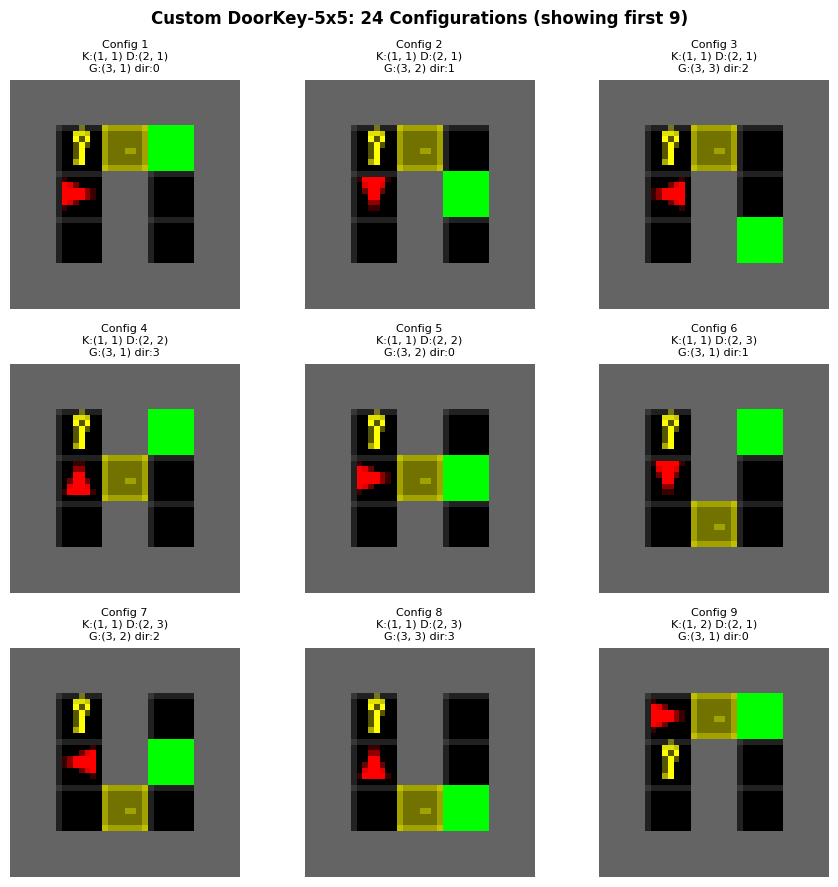


ALL CUSTOM CONFIGURATIONS:
Config  1: Key=(1, 1), Door=(2, 1), Goal=(3, 1)
Config  2: Key=(1, 1), Door=(2, 1), Goal=(3, 2)
Config  3: Key=(1, 1), Door=(2, 1), Goal=(3, 3)
Config  4: Key=(1, 1), Door=(2, 2), Goal=(3, 1)
Config  5: Key=(1, 1), Door=(2, 2), Goal=(3, 2)
Config  6: Key=(1, 1), Door=(2, 3), Goal=(3, 1)
Config  7: Key=(1, 1), Door=(2, 3), Goal=(3, 2)
Config  8: Key=(1, 1), Door=(2, 3), Goal=(3, 3)
Config  9: Key=(1, 2), Door=(2, 1), Goal=(3, 1)
Config 10: Key=(1, 2), Door=(2, 1), Goal=(3, 2)
Config 11: Key=(1, 2), Door=(2, 1), Goal=(3, 3)
Config 12: Key=(1, 2), Door=(2, 2), Goal=(3, 1)
Config 13: Key=(1, 2), Door=(2, 2), Goal=(3, 2)
Config 14: Key=(1, 2), Door=(2, 3), Goal=(3, 1)
Config 15: Key=(1, 2), Door=(2, 3), Goal=(3, 2)
Config 16: Key=(1, 2), Door=(2, 3), Goal=(3, 3)
Config 17: Key=(1, 3), Door=(2, 1), Goal=(3, 1)
Config 18: Key=(1, 3), Door=(2, 1), Goal=(3, 2)
Config 19: Key=(1, 3), Door=(2, 1), Goal=(3, 3)
Config 20: Key=(1, 3), Door=(2, 2), Goal=(3, 1)
Config 21: K

In [14]:
# ============================================================================
# Custom DoorKey-5x5-v0 with Different Key/Door/Goal Positions
# ============================================================================
# Generate ALL valid configurations (3 key × 3 door × 3 goal = 27 total)
# Exclude standard MiniGrid-DoorKey-5x5-v0 pattern: door in middle, goal at bottom
# Also vary agent starting direction across trials for diversity

from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.minigrid_env import MiniGridEnv

class CustomDoorKey5x5(MiniGridEnv):
    """
    Custom DoorKey-5x5 environment with configurable key/door/goal positions
    AND configurable agent starting direction.
    
    Grid layout (5x5):
    - Outer walls at x=0,4 and y=0,4
    - Vertical wall at x=2
    - Left room: x=1, y∈[1,3]
    - Right room: x=3, y∈[1,3]
    
    Valid positions:
    - Key: x=1, y∈{1,2,3} (left room)
    - Door: x=2, y∈{1,2,3} (on wall)
    - Goal: x=3, y∈{1,2,3} (right room)
    - Agent start: x=1, y∈{1,2,3} (left room, not on key)
    - Agent dir: 0=Right, 1=Down, 2=Left, 3=Up
    """
    
    def __init__(
        self,
        key_pos=(1, 3),
        door_pos=(2, 1),
        goal_pos=(3, 3),
        agent_start=(1, 1),
        agent_dir=0,          # NEW: Agent starting direction
        max_steps=100,
        **kwargs
    ):
        self.key_pos = key_pos
        self.door_pos = door_pos
        self.goal_pos = goal_pos
        self.agent_start_pos = agent_start
        self.agent_start_dir = agent_dir  # NEW
        
        mission_space = MissionSpace(mission_func=self._gen_mission)
        
        super().__init__(
            mission_space=mission_space,
            grid_size=5,
            max_steps=max_steps,
            **kwargs
        )
    
    @staticmethod
    def _gen_mission():
        return "use the key to open the door and then get to the goal"
    
    def _gen_grid(self, width, height):
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)
        
        # Vertical wall at x=2
        for y in range(0, height):
            self.grid.set(2, y, Wall())
        
        # Place door, key, goal
        self.grid.set(self.door_pos[0], self.door_pos[1], Door('yellow', is_locked=True))
        self.grid.set(self.key_pos[0], self.key_pos[1], Key('yellow'))
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])
        
        # Place agent with specified position AND direction
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir  # NEW: Use specified direction
        
        self.mission = self._gen_mission()


def make_custom_doorkey(key_pos, door_pos, goal_pos, agent_start=(1, 1), agent_dir=0):
    """Create a custom DoorKey environment with specified positions and agent direction"""
    env = CustomDoorKey5x5(
        key_pos=key_pos,
        door_pos=door_pos,
        goal_pos=goal_pos,
        agent_start=agent_start,
        agent_dir=agent_dir,  # NEW
        render_mode='rgb_array'
    )
    return env


# ============================================================================
# Generate ALL valid configurations
# ============================================================================
# Key positions: (1,1), (1,2), (1,3)
# Door positions: (2,1), (2,2), (2,3)
# Goal positions: (3,1), (3,2), (3,3)
#
# Exclusion: Standard MiniGrid-DoorKey-5x5-v0 is door=(2,2) with goal=(3,3)
# We exclude this specific combination to test on unseen configs

key_positions = [(1, 1), (1, 2), (1, 3)]
door_positions = [(2, 1), (2, 2), (2, 3)]
goal_positions = [(3, 1), (3, 2), (3, 3)]

# Generate all 27 combinations, excluding the standard one
custom_configs = []
excluded_count = 0

for key_pos in key_positions:
    for door_pos in door_positions:
        for goal_pos in goal_positions:
            # Exclude standard MiniGrid-DoorKey-5x5-v0 pattern
            # Standard has door in middle (y=2) and goal at bottom (y=3)
            if door_pos == (2, 2) and goal_pos == (3, 3):
                excluded_count += 1
                print(f"Excluding standard config: Key={key_pos}, Door={door_pos}, Goal={goal_pos}")
                continue
            
            # Find valid agent start position (not on key)
            valid_agent_starts = [(1, y) for y in [1, 2, 3] if (1, y) != key_pos]
            agent_start = valid_agent_starts[0]  # Default start
            
            custom_configs.append({
                "key_pos": key_pos,
                "door_pos": door_pos,
                "goal_pos": goal_pos,
                "agent_start": agent_start
            })

print(f"\n✓ Generated {len(custom_configs)} custom configurations")
print(f"  (Excluded {excluded_count} standard MiniGrid-DoorKey-5x5 patterns)")
print(f"\nNote: Agent direction will be varied across trials (0-3) for diversity")

# Visualize a subset of configurations (first 9)
n_show = min(9, len(custom_configs))
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i in range(n_show):
    config = custom_configs[i]
    env = make_custom_doorkey(**config, agent_dir=i % 4)  # Vary direction for visualization
    env.reset()
    img = get_full_obs(env)
    
    axes[i].imshow(img)
    axes[i].set_title(f'Config {i+1}\nK:{config["key_pos"]} D:{config["door_pos"]}\nG:{config["goal_pos"]} dir:{i%4}', 
                      fontsize=8)
    axes[i].axis('off')
    env.close()

plt.suptitle(f'Custom DoorKey-5x5: {len(custom_configs)} Configurations (showing first 9)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print all configs
print("\n" + "="*70)
print("ALL CUSTOM CONFIGURATIONS:")
print("="*70)
for i, config in enumerate(custom_configs):
    print(f"Config {i+1:2d}: Key={config['key_pos']}, Door={config['door_pos']}, Goal={config['goal_pos']}")


In [15]:
# ============================================================================
# Verify BFS Solvability for ALL Custom Configurations
# ============================================================================
# Test that BFS can solve each config with different agent orientations

def bfs_solve_custom_env(env):
    """
    BFS solver for custom environment instance.
    Returns list of actions to reach the goal, or None if unsolvable.
    
    State: (x, y, dir, carrying, door_open)
    """
    unwrapped = env.unwrapped
    
    DIR_TO_VEC = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    
    start_pos = tuple(unwrapped.agent_pos)
    start_dir = unwrapped.agent_dir
    grid = unwrapped.grid
    
    # Find key and door positions
    key_pos = None
    door_pos = None
    for gx in range(grid.width):
        for gy in range(grid.height):
            cell = grid.get(gx, gy)
            if cell and cell.type == 'key':
                key_pos = (gx, gy)
            if cell and cell.type == 'door':
                door_pos = (gx, gy)
    
    queue = deque([(start_pos[0], start_pos[1], start_dir, [], None, False)])
    visited = set([(start_pos[0], start_pos[1], start_dir, None, False)])
    
    while queue:
        x, y, d, actions, carrying, door_open = queue.popleft()
        
        dx, dy = DIR_TO_VEC[d]
        fx, fy = x + dx, y + dy
        
        if 0 <= fx < grid.width and 0 <= fy < grid.height:
            cell = grid.get(fx, fy)
            
            # Goal reached
            if cell and cell.type == 'goal':
                return actions + [unwrapped.actions.forward]
            
            # Pick up key
            if cell and cell.type == 'key' and carrying is None:
                new_carrying = 'key'
                new_state = (x, y, d, new_carrying, door_open)
                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((x, y, d, actions + [unwrapped.actions.pickup], new_carrying, door_open))
            
            # Open door (must have key)
            if cell and cell.type == 'door' and not door_open and carrying == 'key':
                new_state = (fx, fy, d, carrying, True)
                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((fx, fy, d, actions + [unwrapped.actions.toggle, unwrapped.actions.forward], carrying, True))
            
            # Move forward
            cell_is_key_picked = (key_pos == (fx, fy) and carrying == 'key')
            can_move = (cell is None) or \
                       (cell and cell.type == 'door' and door_open) or \
                       (cell and cell.type == 'goal') or \
                       cell_is_key_picked
            
            if can_move:
                state = (fx, fy, d, carrying, door_open)
                if state not in visited:
                    visited.add(state)
                    queue.append((fx, fy, d, actions + [unwrapped.actions.forward], carrying, door_open))
        
        # Turn left/right
        for turn in [-1, 1]:
            td = (d + turn) % 4
            state = (x, y, td, carrying, door_open)
            if state not in visited:
                visited.add(state)
                action = unwrapped.actions.left if turn == -1 else unwrapped.actions.right
                queue.append((x, y, td, actions + [action], carrying, door_open))
    
    return None


# ============================================================================
# Verify ALL configs are solvable with ALL agent directions
# ============================================================================

print("="*70)
print("VERIFYING BFS SOLVABILITY FOR ALL CONFIGURATIONS")
print("Testing each config with agent directions 0, 1, 2, 3")
print("="*70)

failed_configs = []
solved_configs = []

for config_idx, config in enumerate(custom_configs):
    config_name = f"Config {config_idx+1}: K={config['key_pos']}, D={config['door_pos']}, G={config['goal_pos']}"
    all_dirs_solved = True
    dir_results = []
    
    for agent_dir in [0, 1, 2, 3]:
        # Find valid agent start (not on key)
        valid_starts = [(1, y) for y in [1, 2, 3] if (1, y) != config['key_pos']]
        agent_start = valid_starts[0]
        
        env = make_custom_doorkey(
            key_pos=config['key_pos'],
            door_pos=config['door_pos'],
            goal_pos=config['goal_pos'],
            agent_start=agent_start,
            agent_dir=agent_dir
        )
        env.reset()
        
        actions = bfs_solve_custom_env(env)
        env.close()
        
        if actions is None:
            all_dirs_solved = False
            dir_results.append(f"dir={agent_dir}: ✗")
        else:
            dir_results.append(f"dir={agent_dir}: ✓ ({len(actions)} steps)")
    
    if all_dirs_solved:
        print(f"✓ {config_name}")
        solved_configs.append(config_idx)
    else:
        print(f"✗ {config_name}")
        for r in dir_results:
            print(f"    {r}")
        failed_configs.append(config_idx)

print("\n" + "="*70)
print(f"SUMMARY: {len(solved_configs)}/{len(custom_configs)} configs solvable with all directions")
print("="*70)

if failed_configs:
    print(f"\n⚠️ WARNING: {len(failed_configs)} configs have unsolvable directions!")
    print("These will be skipped during evaluation.")
else:
    print("\n✓ All configurations are solvable with all agent directions!")

# Remove failed configs from the list
if failed_configs:
    custom_configs = [c for i, c in enumerate(custom_configs) if i not in failed_configs]
    print(f"\nUpdated custom_configs: {len(custom_configs)} valid configurations")


VERIFYING BFS SOLVABILITY FOR ALL CONFIGURATIONS
Testing each config with agent directions 0, 1, 2, 3
✓ Config 1: K=(1, 1), D=(2, 1), G=(3, 1)
✓ Config 2: K=(1, 1), D=(2, 1), G=(3, 2)
✓ Config 3: K=(1, 1), D=(2, 1), G=(3, 3)
✓ Config 4: K=(1, 1), D=(2, 2), G=(3, 1)
✓ Config 5: K=(1, 1), D=(2, 2), G=(3, 2)
✓ Config 6: K=(1, 1), D=(2, 3), G=(3, 1)
✓ Config 7: K=(1, 1), D=(2, 3), G=(3, 2)
✓ Config 8: K=(1, 1), D=(2, 3), G=(3, 3)
✓ Config 9: K=(1, 2), D=(2, 1), G=(3, 1)
✓ Config 10: K=(1, 2), D=(2, 1), G=(3, 2)
✓ Config 11: K=(1, 2), D=(2, 1), G=(3, 3)
✓ Config 12: K=(1, 2), D=(2, 2), G=(3, 1)
✓ Config 13: K=(1, 2), D=(2, 2), G=(3, 2)
✓ Config 14: K=(1, 2), D=(2, 3), G=(3, 1)
✓ Config 15: K=(1, 2), D=(2, 3), G=(3, 2)
✓ Config 16: K=(1, 2), D=(2, 3), G=(3, 3)
✓ Config 17: K=(1, 3), D=(2, 1), G=(3, 1)
✓ Config 18: K=(1, 3), D=(2, 1), G=(3, 2)
✓ Config 19: K=(1, 3), D=(2, 1), G=(3, 3)
✓ Config 20: K=(1, 3), D=(2, 2), G=(3, 1)
✓ Config 21: K=(1, 3), D=(2, 2), G=(3, 2)
✓ Config 22: K=(1, 3), D=

Evaluating on custom DoorKey configurations (varied agent configs)...

Config 1/24
Key=(1, 1), Door=(2, 1), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 9 steps


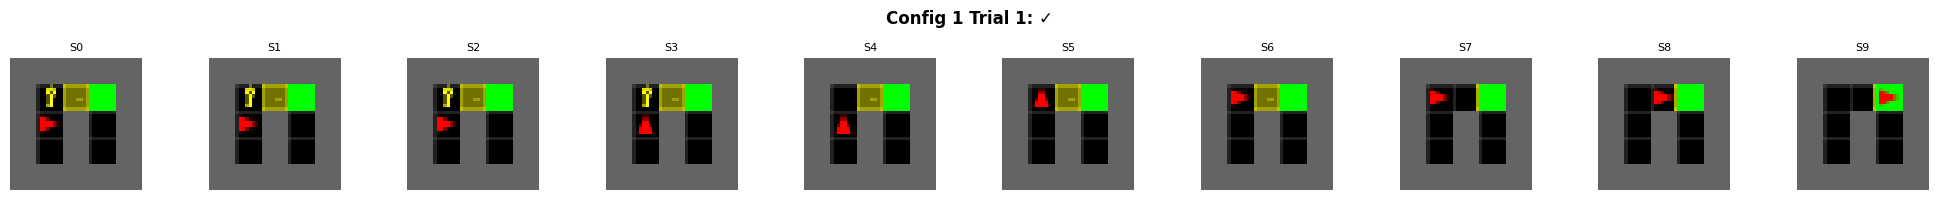

  Trial 2 (dir=1): ✓ 8 steps
  Trial 3 (dir=2): ✓ 8 steps
  Trial 4 (dir=3): ✓ 6 steps

  Config 1 Result: 100.0% success, 7.8 avg steps

Config 2/24
Key=(1, 1), Door=(2, 1), Goal=(3, 2)
  Trial 1 (dir=0): ✓ 9 steps


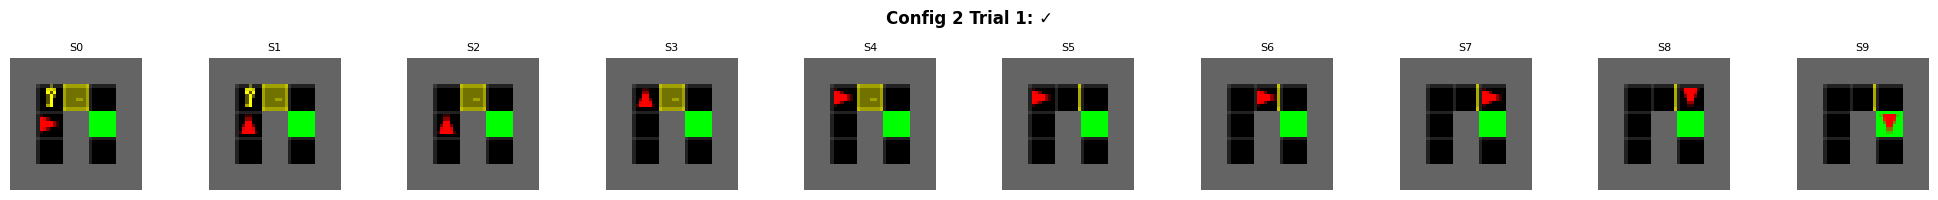

  Trial 2 (dir=1): ✓ 11 steps
  Trial 3 (dir=2): ✓ 10 steps
  Trial 4 (dir=3): ✓ 8 steps

  Config 2 Result: 100.0% success, 9.5 avg steps

Config 3/24
Key=(1, 1), Door=(2, 1), Goal=(3, 3)
  Trial 1 (dir=0): ✓ 10 steps


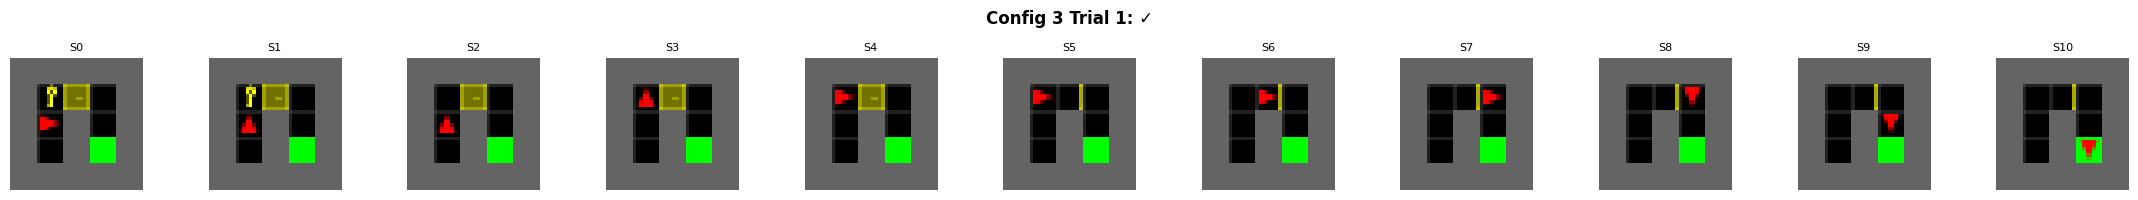

  Trial 2 (dir=1): ✓ 11 steps
  Trial 3 (dir=2): ✓ 10 steps
  Trial 4 (dir=3): ✓ 9 steps

  Config 3 Result: 100.0% success, 10.0 avg steps

Config 4/24
Key=(1, 1), Door=(2, 2), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 10 steps


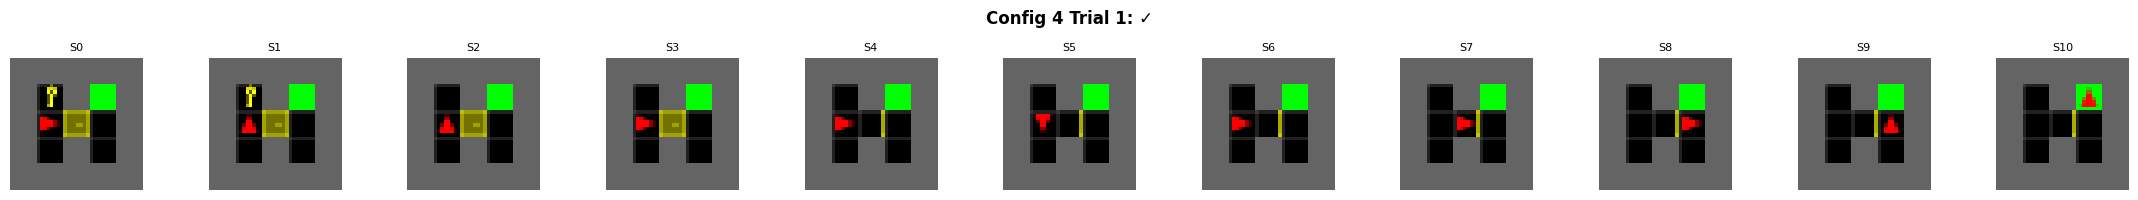

  Trial 2 (dir=1): ✓ 9 steps
  Trial 3 (dir=2): ✓ 8 steps
  Trial 4 (dir=3): ✓ 7 steps

  Config 4 Result: 100.0% success, 8.5 avg steps

Config 5/24
Key=(1, 1), Door=(2, 2), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


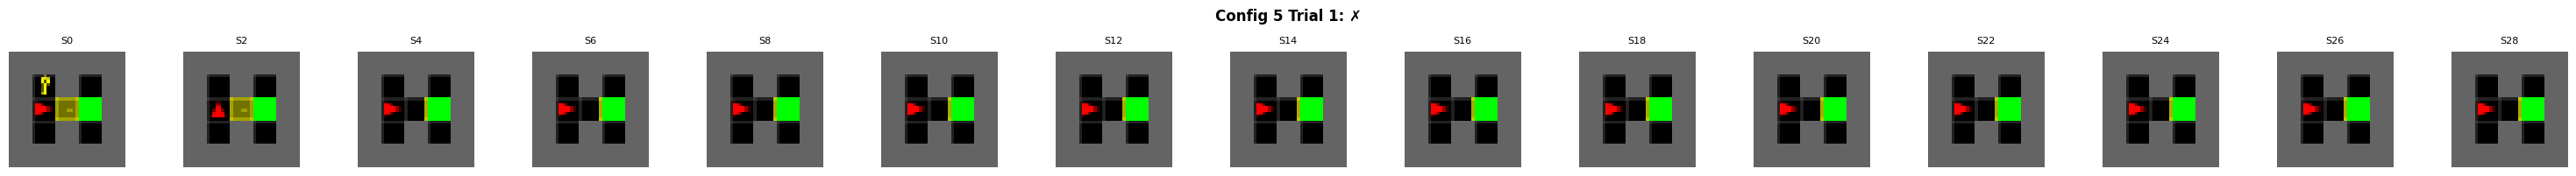

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 5 Result: 0.0% success, 0.0 avg steps

Config 6/24
Key=(1, 1), Door=(2, 3), Goal=(3, 1)
  Trial 1 (dir=0): ✗ Failed


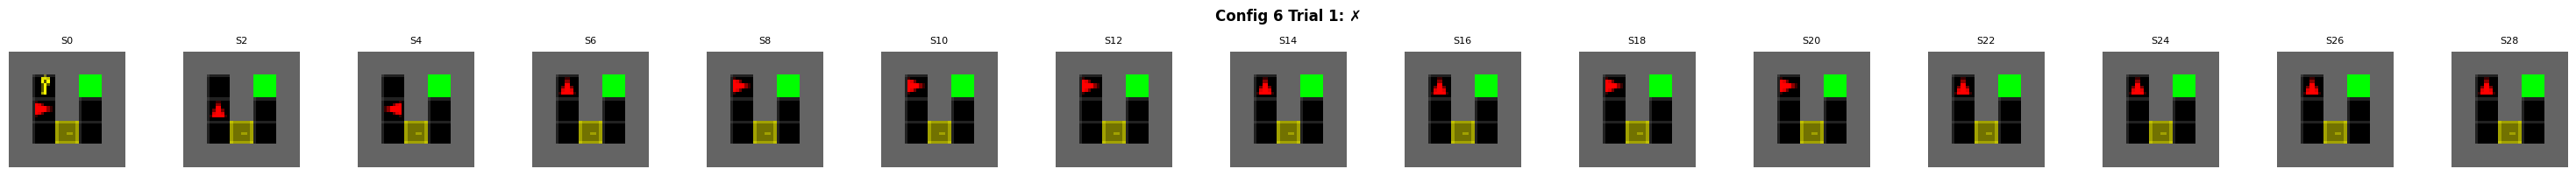

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 6 Result: 0.0% success, 0.0 avg steps

Config 7/24
Key=(1, 1), Door=(2, 3), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


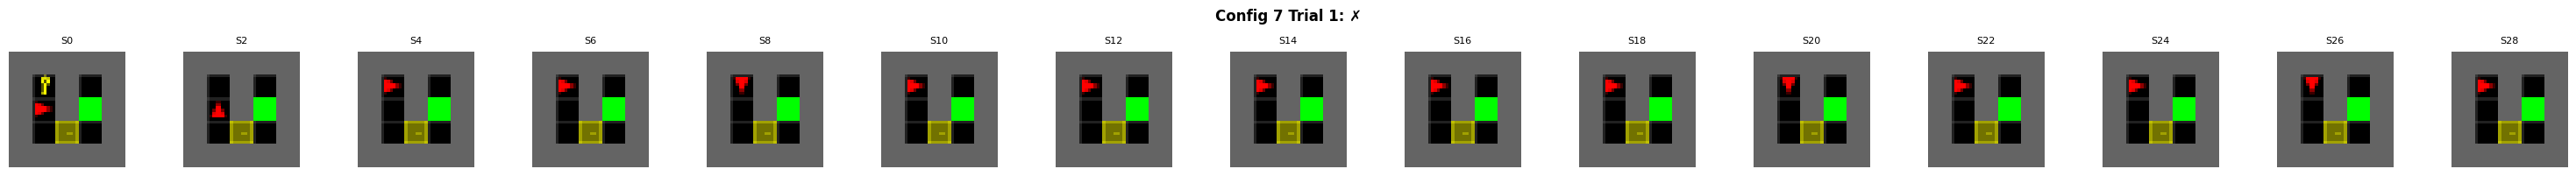

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 7 Result: 0.0% success, 0.0 avg steps

Config 8/24
Key=(1, 1), Door=(2, 3), Goal=(3, 3)
  Trial 1 (dir=0): ✗ Failed


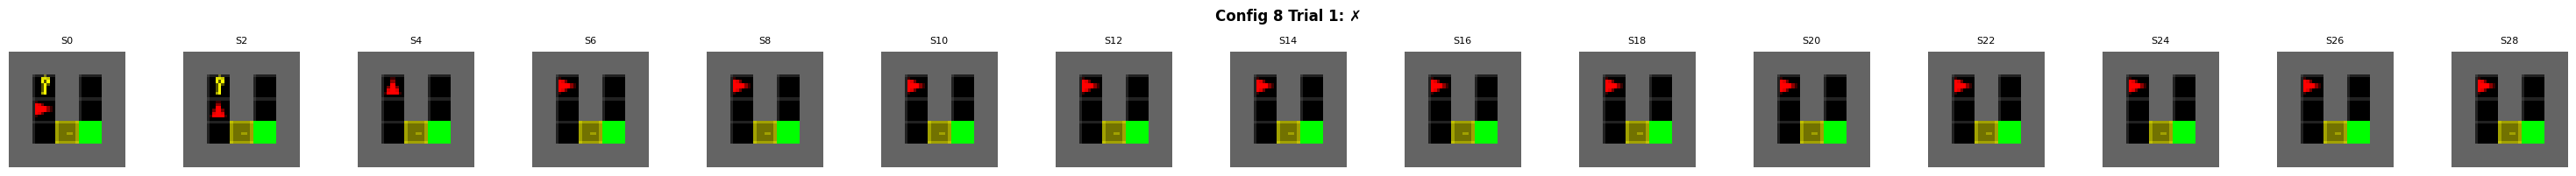

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 8 Result: 0.0% success, 0.0 avg steps

Config 9/24
Key=(1, 2), Door=(2, 1), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 6 steps


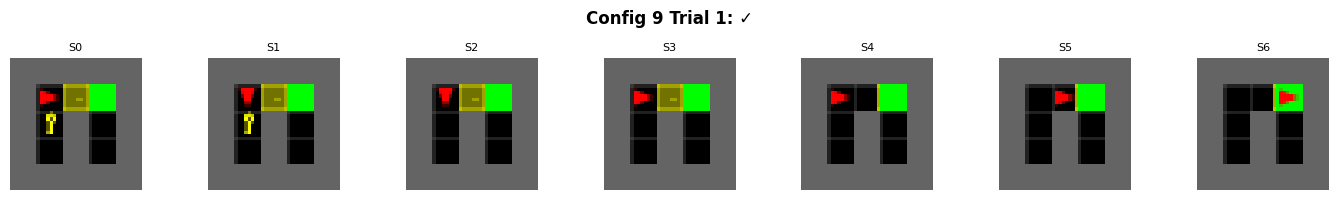

  Trial 2 (dir=1): ✓ 5 steps
  Trial 3 (dir=2): ✓ 6 steps
  Trial 4 (dir=3): ✓ 7 steps

  Config 9 Result: 100.0% success, 6.0 avg steps

Config 10/24
Key=(1, 2), Door=(2, 1), Goal=(3, 2)
  Trial 1 (dir=0): ✓ 8 steps


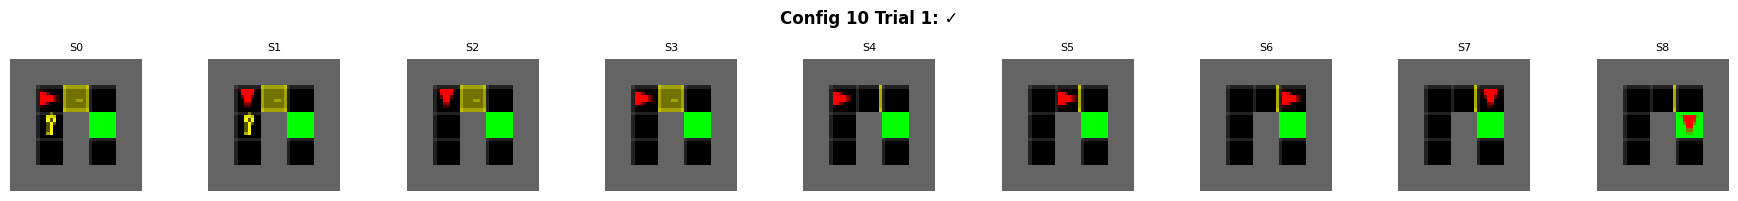

  Trial 2 (dir=1): ✓ 7 steps
  Trial 3 (dir=2): ✓ 8 steps
  Trial 4 (dir=3): ✓ 9 steps

  Config 10 Result: 100.0% success, 8.0 avg steps

Config 11/24
Key=(1, 2), Door=(2, 1), Goal=(3, 3)
  Trial 1 (dir=0): ✓ 9 steps


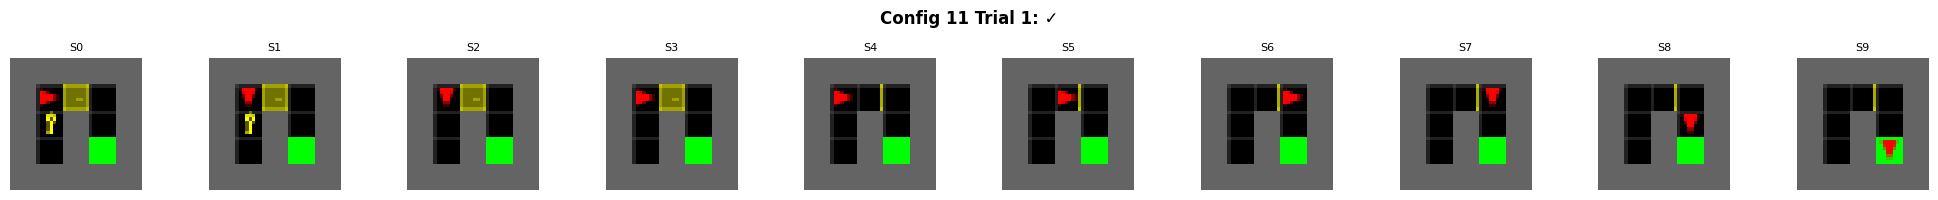

  Trial 2 (dir=1): ✓ 8 steps
  Trial 3 (dir=2): ✓ 9 steps
  Trial 4 (dir=3): ✓ 12 steps

  Config 11 Result: 100.0% success, 9.5 avg steps

Config 12/24
Key=(1, 2), Door=(2, 2), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 10 steps


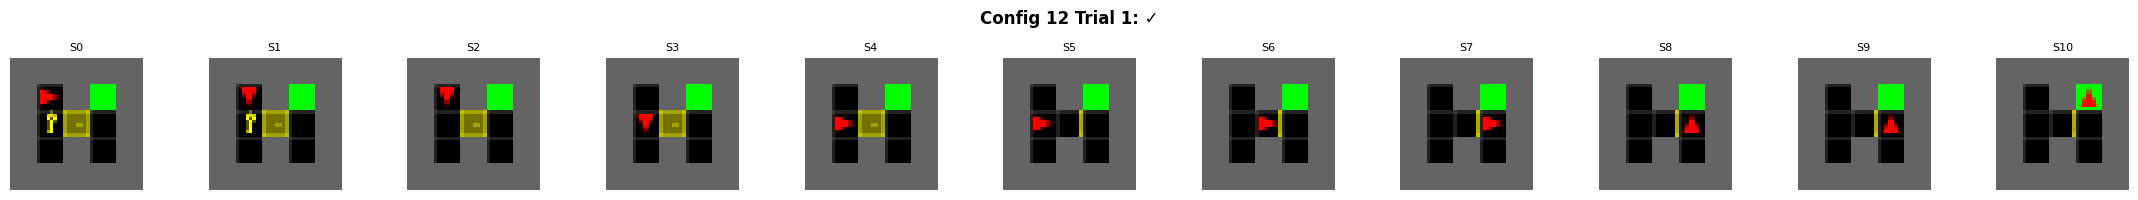

  Trial 2 (dir=1): ✓ 10 steps
  Trial 3 (dir=2): ✓ 11 steps
  Trial 4 (dir=3): ✓ 10 steps

  Config 12 Result: 100.0% success, 10.2 avg steps

Config 13/24
Key=(1, 2), Door=(2, 2), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


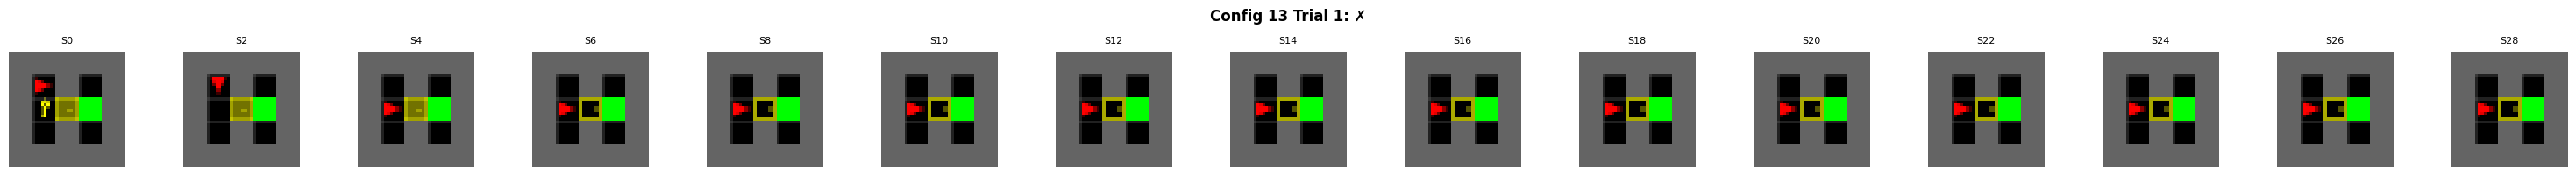

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 13 Result: 0.0% success, 0.0 avg steps

Config 14/24
Key=(1, 2), Door=(2, 3), Goal=(3, 1)
  Trial 1 (dir=0): ✗ Failed


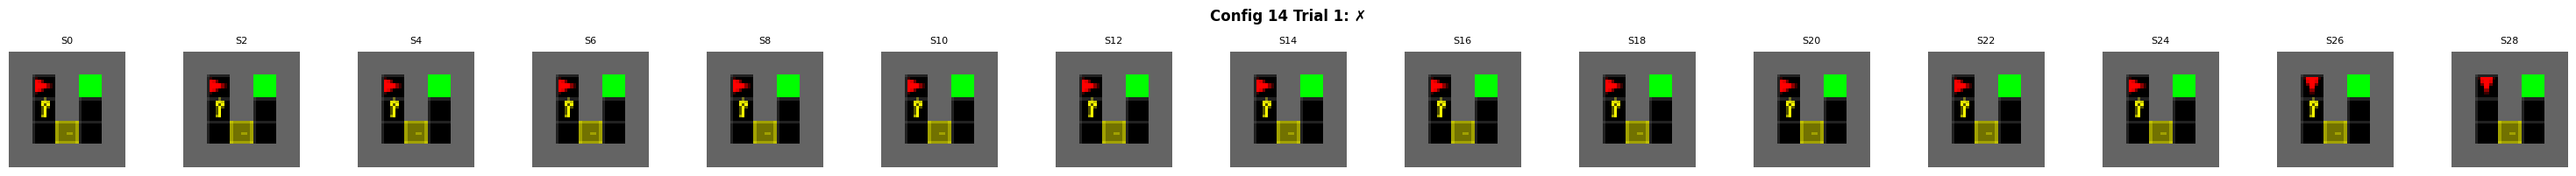

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 14 Result: 0.0% success, 0.0 avg steps

Config 15/24
Key=(1, 2), Door=(2, 3), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


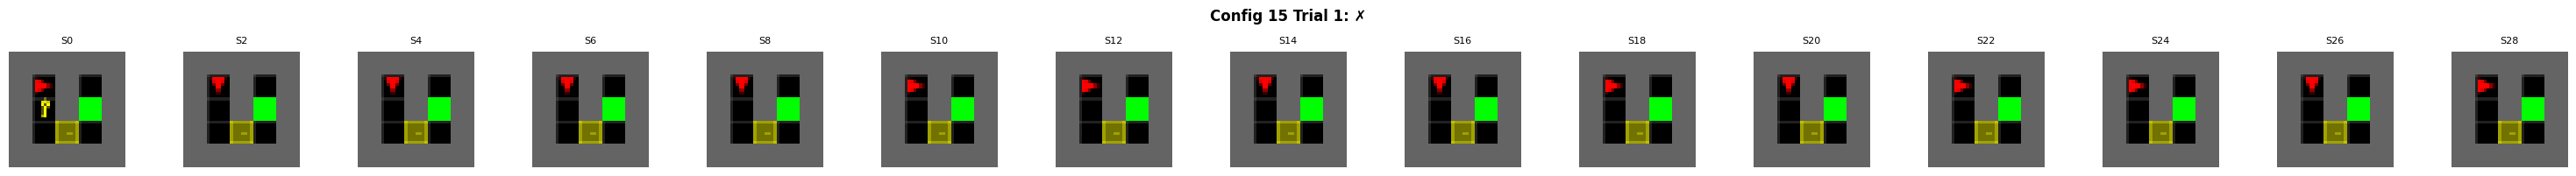

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 15 Result: 0.0% success, 0.0 avg steps

Config 16/24
Key=(1, 2), Door=(2, 3), Goal=(3, 3)
  Trial 1 (dir=0): ✗ Failed


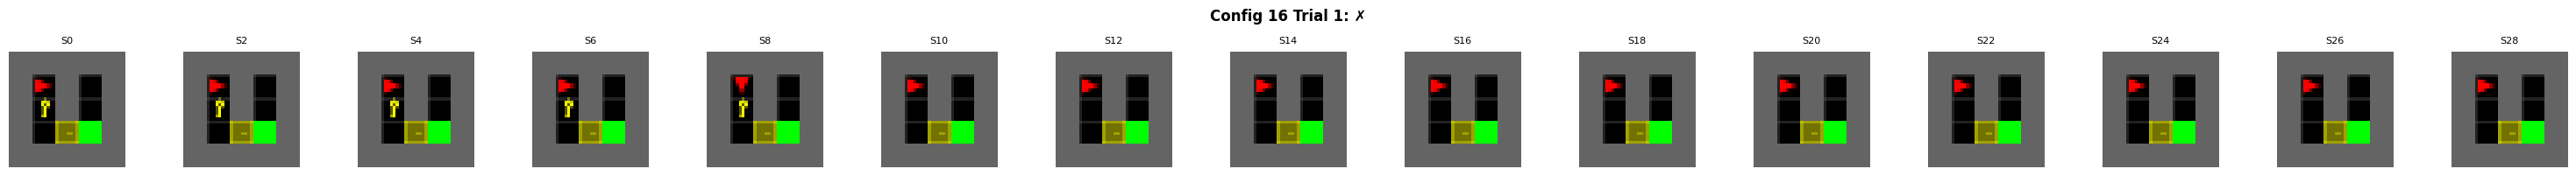

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 16 Result: 0.0% success, 0.0 avg steps

Config 17/24
Key=(1, 3), Door=(2, 1), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 11 steps


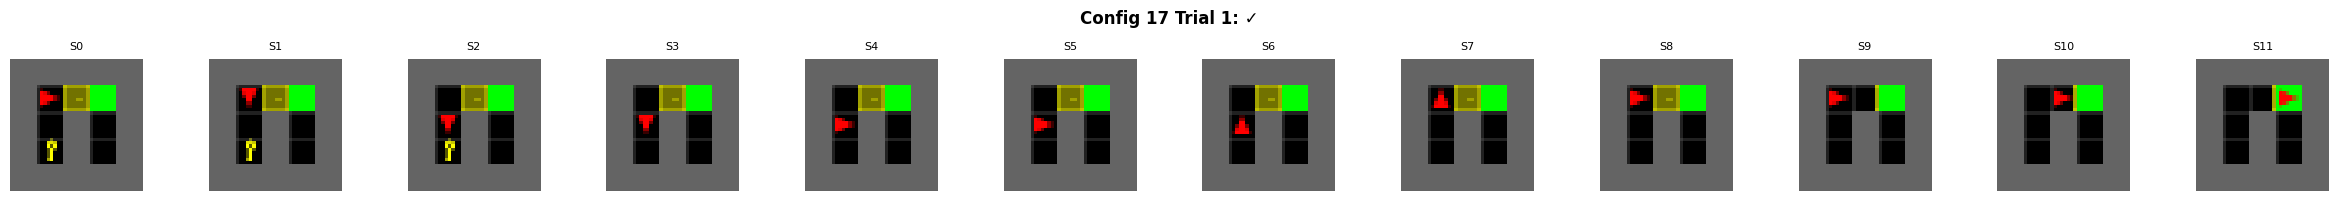

  Trial 2 (dir=1): ✓ 9 steps
  Trial 3 (dir=2): ✓ 12 steps
  Trial 4 (dir=3): ✓ 15 steps

  Config 17 Result: 100.0% success, 11.8 avg steps

Config 18/24
Key=(1, 3), Door=(2, 1), Goal=(3, 2)
  Trial 1 (dir=0): ✓ 12 steps


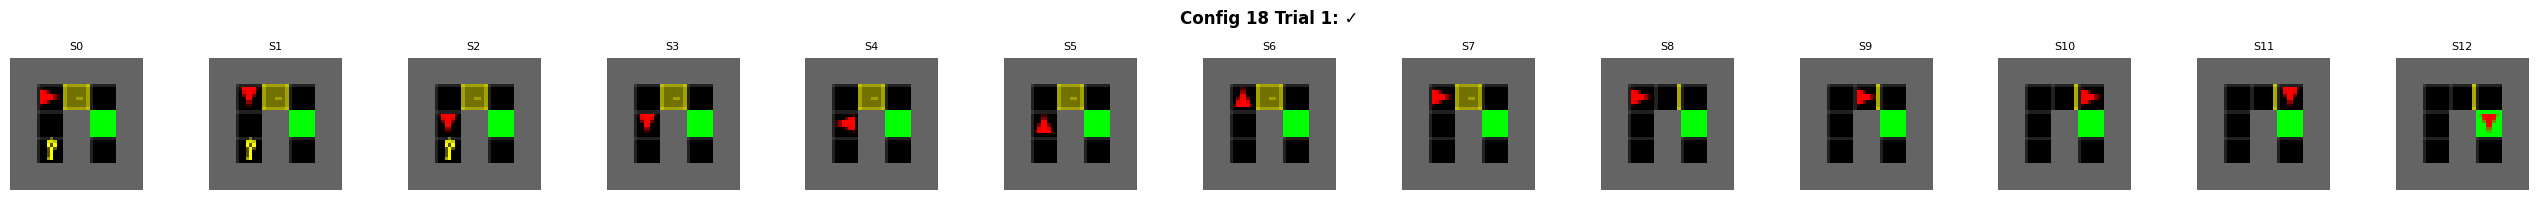

  Trial 2 (dir=1): ✓ 12 steps
  Trial 3 (dir=2): ✓ 13 steps
  Trial 4 (dir=3): ✓ 15 steps

  Config 18 Result: 100.0% success, 13.0 avg steps

Config 19/24
Key=(1, 3), Door=(2, 1), Goal=(3, 3)
  Trial 1 (dir=0): ✓ 14 steps


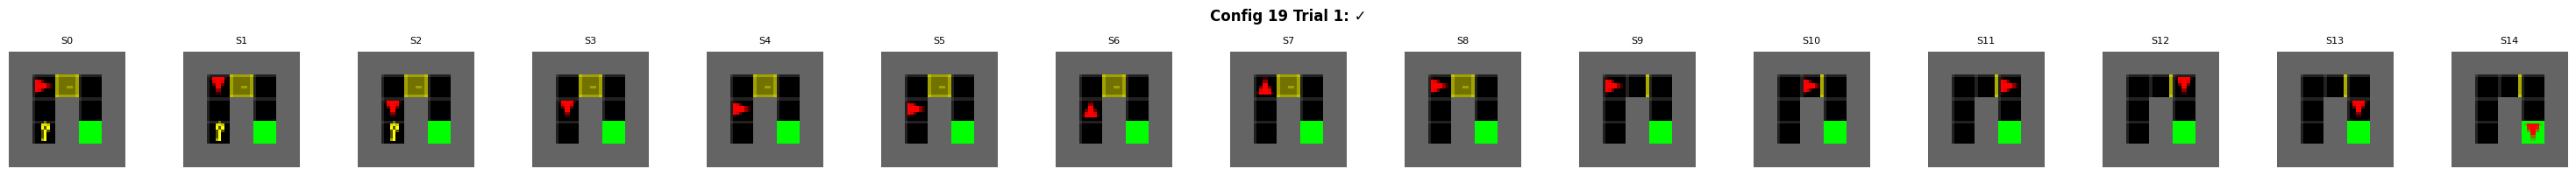

  Trial 2 (dir=1): ✓ 13 steps
  Trial 3 (dir=2): ✓ 13 steps
  Trial 4 (dir=3): ✓ 18 steps

  Config 19 Result: 100.0% success, 14.5 avg steps

Config 20/24
Key=(1, 3), Door=(2, 2), Goal=(3, 1)
  Trial 1 (dir=0): ✓ 13 steps


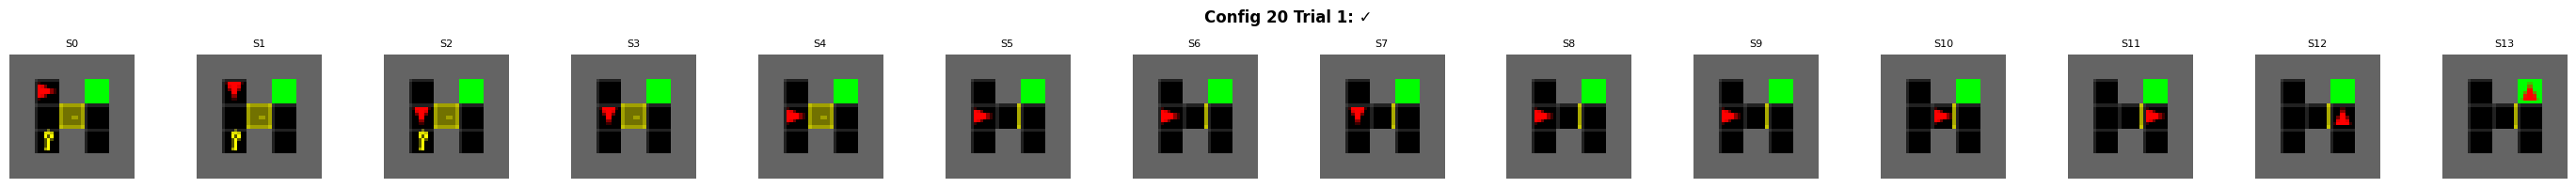

  Trial 2 (dir=1): ✓ 10 steps
  Trial 3 (dir=2): ✓ 9 steps
  Trial 4 (dir=3): ✓ 14 steps

  Config 20 Result: 100.0% success, 11.5 avg steps

Config 21/24
Key=(1, 3), Door=(2, 2), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


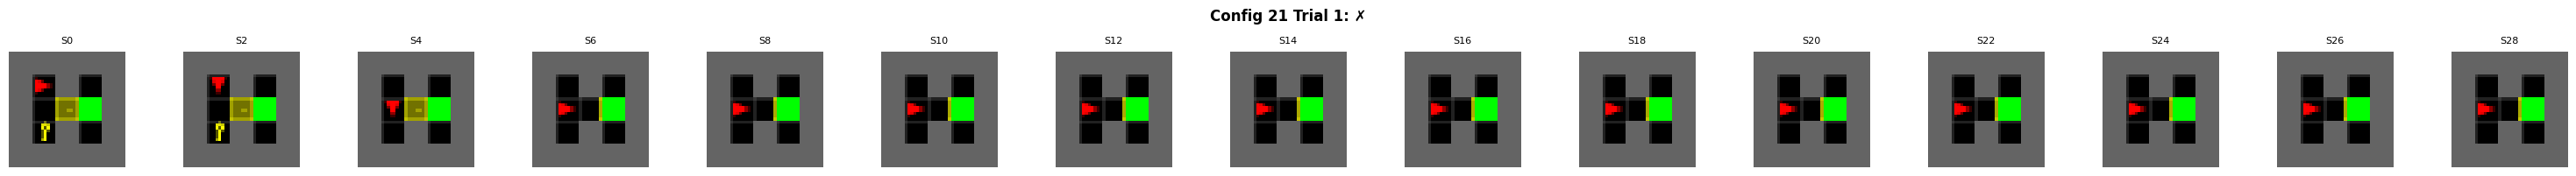

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 21 Result: 0.0% success, 0.0 avg steps

Config 22/24
Key=(1, 3), Door=(2, 3), Goal=(3, 1)
  Trial 1 (dir=0): ✗ Failed


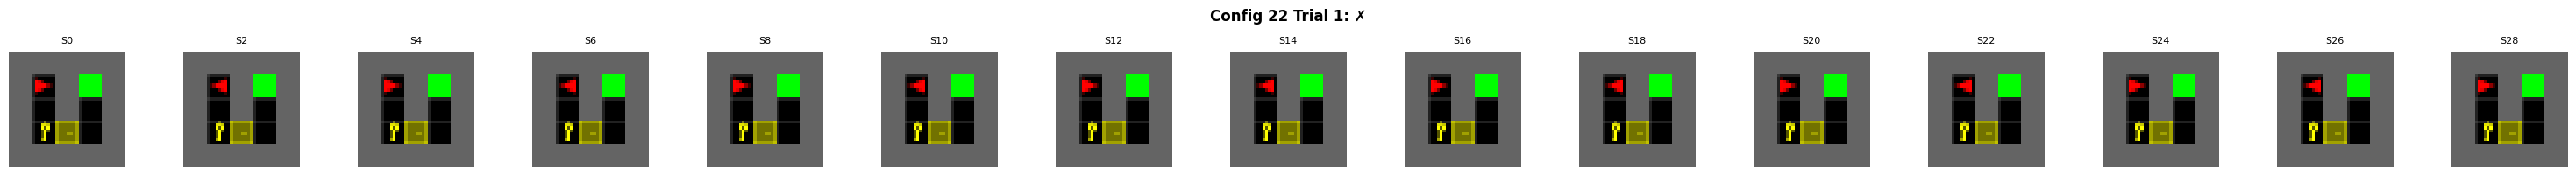

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 22 Result: 0.0% success, 0.0 avg steps

Config 23/24
Key=(1, 3), Door=(2, 3), Goal=(3, 2)
  Trial 1 (dir=0): ✗ Failed


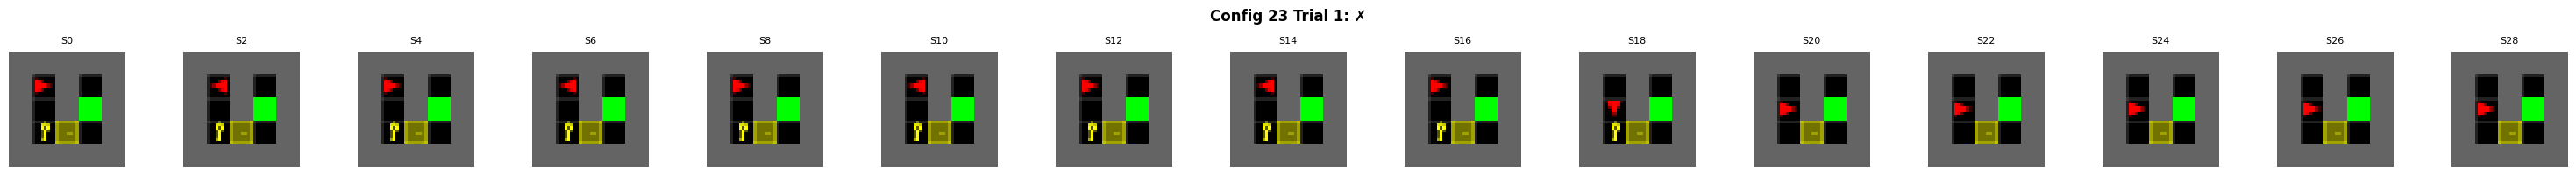

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 23 Result: 0.0% success, 0.0 avg steps

Config 24/24
Key=(1, 3), Door=(2, 3), Goal=(3, 3)
  Trial 1 (dir=0): ✗ Failed


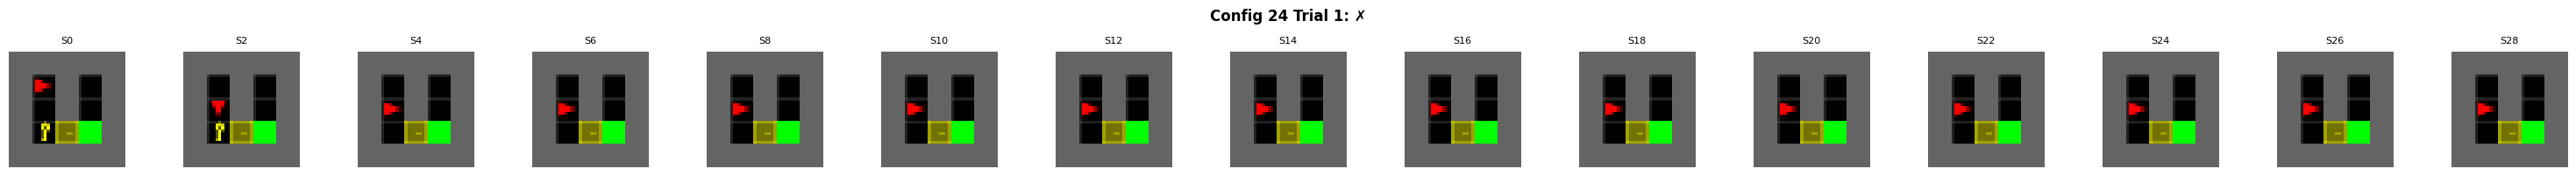

  Trial 2 (dir=1): ✗ Failed
  Trial 3 (dir=2): ✗ Failed
  Trial 4 (dir=3): ✗ Failed

  Config 24 Result: 0.0% success, 0.0 avg steps

SUMMARY
Overall: 48/96 (50.0%)


In [18]:
# ============================================================================
# Evaluate Model on Custom DoorKey-5x5 Configurations
# ============================================================================
# Test generalization with VARIED agent start positions and directions

def evaluate_custom_doorkey(model, planner, custom_configs, num_trials_per_config=4, 
                            max_steps=30, replan_every=1, visualize=False):
    """
    Evaluate model on custom DoorKey configurations with replanning.
    Each trial uses a DIFFERENT agent start position and direction for diversity.
    """
    model.eval()
    all_results = []
    
    for config_idx, config in enumerate(custom_configs):
        print(f"\n{'='*60}")
        print(f"Config {config_idx+1}/{len(custom_configs)}")
        print(f"Key={config['key_pos']}, Door={config['door_pos']}, Goal={config['goal_pos']}")
        print(f"{'='*60}")
        
        # Generate agent variations
        valid_starts = [(1, y) for y in [1, 2, 3] if (1, y) != config['key_pos']]
        agent_dirs = [0, 1, 2, 3]
        agent_variations = [(s, d) for s in valid_starts for d in agent_dirs]
        
        config_successes = []
        config_steps = []
        
        for trial in range(num_trials_per_config):
            # VARY agent config across trials
            agent_start, agent_dir = agent_variations[trial % len(agent_variations)]
            
            env = make_custom_doorkey(
                key_pos=config['key_pos'],
                door_pos=config['door_pos'],
                goal_pos=config['goal_pos'],
                agent_start=agent_start,
                agent_dir=agent_dir
            )
            env.reset()
            
            bfs_actions = bfs_solve_custom_env(env)
            if bfs_actions is None:
                print(f"  Trial {trial+1}: BFS failed - skipping")
                env.close()
                continue
            
            env.reset()
            for a in bfs_actions:
                env.step(a)
            goal_obs = get_full_obs(env)
            
            env.reset()
            
            goal_tensor = torch.FloatTensor(goal_obs).permute(2,0,1).unsqueeze(0) / 255.0
            z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
            
            episode_images = []
            episode_distances = []
            episode_actions = []
            
            current_obs = get_full_obs(env)
            episode_images.append(current_obs.copy())
            current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
            with torch.no_grad():
                z_current = model.encode(current_tensor.to(device)).squeeze(0)
                distance = torch.norm(z_current - z_goal).item()
                episode_distances.append(distance)
            
            total_steps = 0
            done = False
            success = False
            
            while total_steps < max_steps and not done:
                with torch.no_grad():
                    z_current = model.encode(current_tensor.to(device)).squeeze(0)
                    actions = planner.plan(z_current, z_goal, verbose=False)
                
                for a_idx in range(min(replan_every, len(actions))):
                    action = int(actions[a_idx].cpu().numpy())
                    episode_actions.append(action)
                    
                    obs, reward, done, truncated, _ = env.step(action)
                    total_steps += 1
                    
                    current_obs = get_full_obs(env)
                    episode_images.append(current_obs.copy())
                    current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
                    with torch.no_grad():
                        z_current = model.encode(current_tensor.to(device)).squeeze(0)
                        distance = torch.norm(z_current - z_goal).item()
                        episode_distances.append(distance)
                    
                    if done:
                        success = True
                        config_successes.append(1)
                        config_steps.append(total_steps)
                        print(f"  Trial {trial+1} (dir={agent_dir}): ✓ {total_steps} steps")
                        break
                    
                    if total_steps >= max_steps:
                        break
                
                if done or total_steps >= max_steps:
                    break
            
            if not success:
                config_successes.append(0)
                print(f"  Trial {trial+1} (dir={agent_dir}): ✗ Failed")
            
            env.close()
            
            # Visualize first trial only
            if visualize and trial == 0:
                n_frames = min(len(episode_images), 15)
                fig, axes = plt.subplots(1, n_frames, figsize=(2*n_frames, 2))
                for i in range(n_frames):
                    idx = i * len(episode_images) // n_frames
                    axes[i].imshow(episode_images[idx])
                    axes[i].set_title(f'S{idx}', fontsize=8)
                    axes[i].axis('off')
                plt.suptitle(f'Config {config_idx+1} Trial 1: {"✓" if success else "✗"}', fontweight='bold')
                plt.tight_layout()
                plt.show()
        
        success_rate = np.mean(config_successes) * 100 if config_successes else 0
        avg_steps = np.mean(config_steps) if config_steps else 0
        
        all_results.append({
            'config_idx': config_idx,
            'config': config,
            'success_rate': success_rate,
            'avg_steps': avg_steps,
            'num_successes': sum(config_successes),
            'num_trials': len(config_successes)
        })
        
        print(f"\n  Config {config_idx+1} Result: {success_rate:.1f}% success, {avg_steps:.1f} avg steps")
    
    # Summary
    print(f"\n{'='*60}")
    print("SUMMARY")
    print(f"{'='*60}")
    total_successes = sum(r['num_successes'] for r in all_results)
    total_trials = sum(r['num_trials'] for r in all_results)
    print(f"Overall: {total_successes}/{total_trials} ({100*total_successes/total_trials:.1f}%)")
    
    return all_results


# Create planner for evaluation
planner_eval = CEMPlanner(
    model_best,
    action_dim=7,
    horizon=15,
    num_iterations=15,
    num_samples=500,
    num_elites=50
)

# Run evaluation
print("Evaluating on custom DoorKey configurations (varied agent configs)...")
custom_results = evaluate_custom_doorkey(
    model_best, 
    planner_eval, 
    custom_configs, 
    num_trials_per_config=4,
    max_steps=30,
    replan_every=1,
    visualize=True
)


REPLANNING FREQUENCY ANALYSIS: 24 Custom DoorKey-5x5 Configs
Trials per config: 4 (varied agent start & direction)
Replan steps: [1, 3, 6, 9, 12, 15]

######################################################################
# Config 1/24: Key=(1, 1), Door=(2, 1), Goal=(3, 1)
######################################################################
  Agent variations: 8 unique (start, dir) combinations
  Valid starts: [(1, 2), (1, 3)]
  Directions: 0=Right, 1=Down, 2=Left, 3=Up

  Testing replan_every = 1...
    100.0% success (4/4), 7.0 avg steps

  Testing replan_every = 3...
    100.0% success (4/4), 8.5 avg steps

  Testing replan_every = 6...
    100.0% success (4/4), 10.2 avg steps

  Testing replan_every = 9...
    100.0% success (4/4), 10.5 avg steps

  Testing replan_every = 12...
    100.0% success (4/4), 16.5 avg steps

  Testing replan_every = 15...
    75.0% success (3/4), 18.7 avg steps

######################################################################
# Config 2/24: Key=(

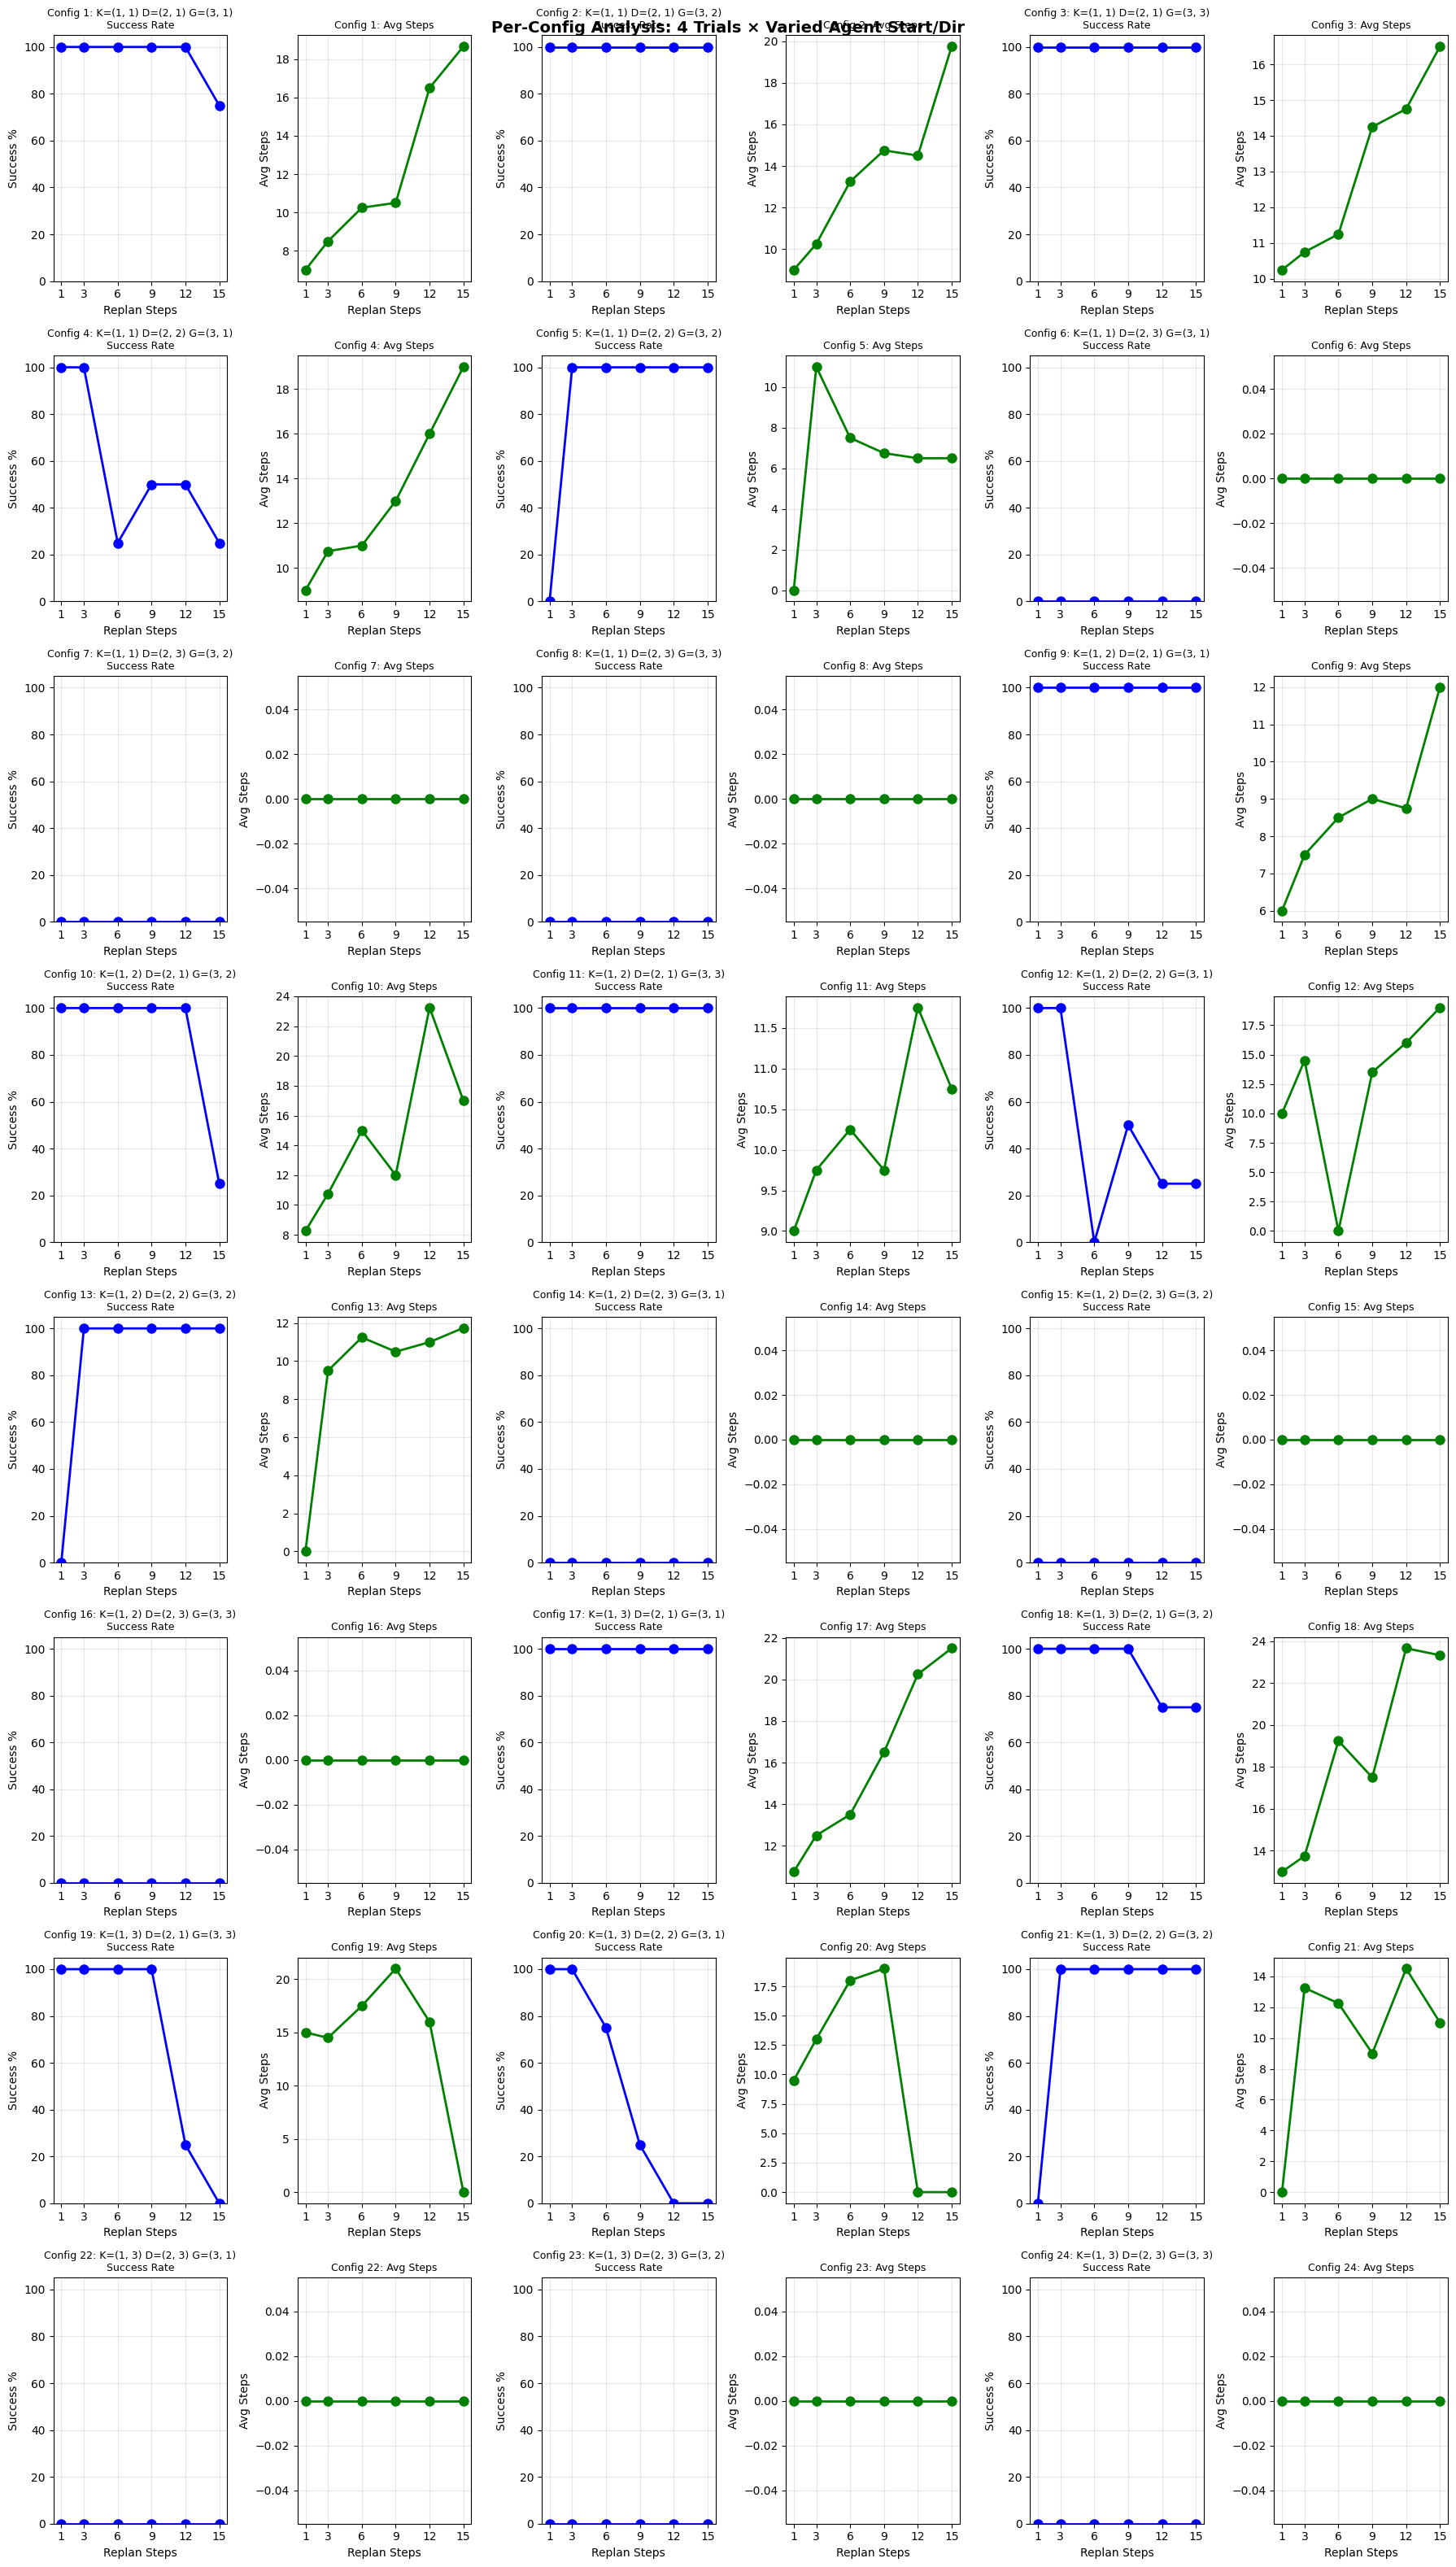

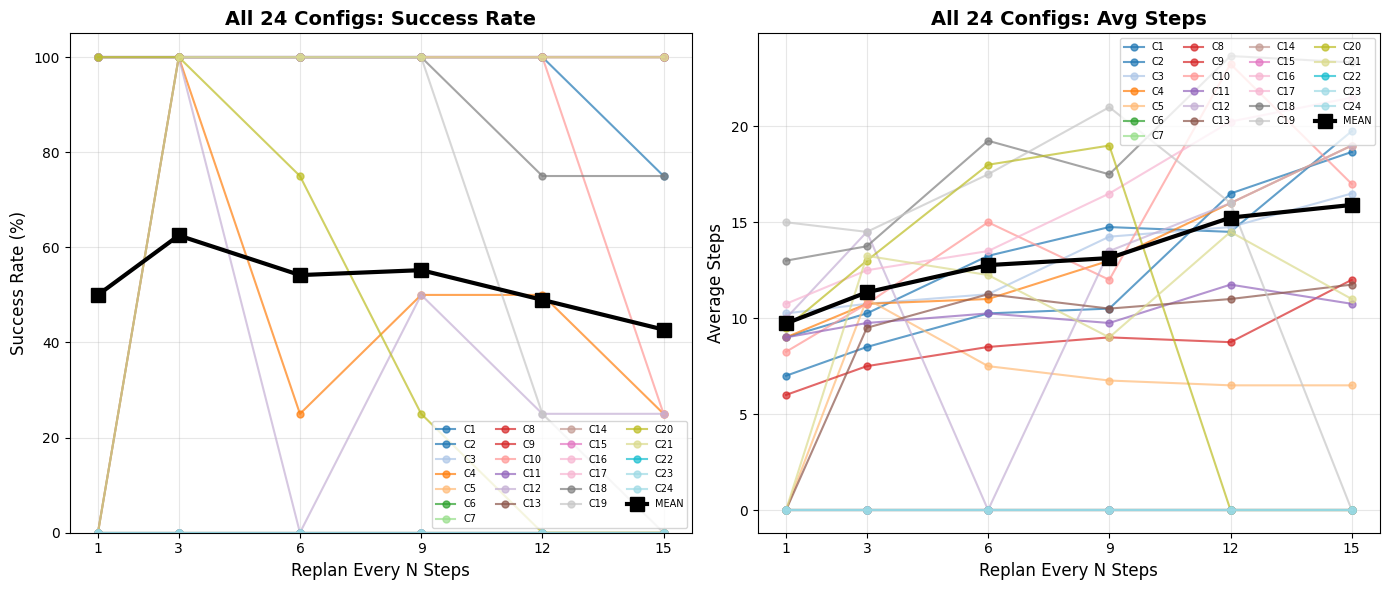


SUMMARY: 24 Configs × 4 Trials (Varied Agent Start/Direction)

--- Config 1: Key=(1, 1), Door=(2, 1), Goal=(3, 1) ---
Replan     Success%     AvgSteps     N
--------------------------------------------------
1          100.0        7.0          4/4
3          100.0        8.5          4/4
6          100.0        10.2         4/4
9          100.0        10.5         4/4
12         100.0        16.5         4/4
15         75.0         18.7         3/4

--- Config 2: Key=(1, 1), Door=(2, 1), Goal=(3, 2) ---
Replan     Success%     AvgSteps     N
--------------------------------------------------
1          100.0        9.0          4/4
3          100.0        10.2         4/4
6          100.0        13.2         4/4
9          100.0        14.8         4/4
12         100.0        14.5         4/4
15         100.0        19.8         4/4

--- Config 3: Key=(1, 1), Door=(2, 1), Goal=(3, 3) ---
Replan     Success%     AvgSteps     N
--------------------------------------------------
1      

In [20]:
# ============================================================================
# Evaluate Across Different Replanning Frequencies - VARIED AGENT CONFIGS
# ============================================================================
# 50 trials per config with VARIED agent start positions and directions
# This ensures we're testing unique trajectories, not repeating the same one

def evaluate_replan_frequencies_per_config(model, custom_configs, replan_values, 
                                           num_trials_per_config=50, max_steps=30, verbose=True):
    """
    Evaluate model on custom configs across different replanning frequencies.
    
    KEY: Each trial uses a DIFFERENT agent start position and direction!
    - 3 valid start positions × 4 directions = 12 unique initial states per config
    - With 50 trials, we cycle through these combinations ~4 times
    """
    results_by_config = {}
    
    for config_idx, config in enumerate(custom_configs):
        print(f"\n{'#'*70}")
        print(f"# Config {config_idx+1}/{len(custom_configs)}: Key={config['key_pos']}, Door={config['door_pos']}, Goal={config['goal_pos']}")
        print(f"{'#'*70}")
        
        results_by_config[config_idx] = {}
        
        # Generate all valid agent start positions (not on key)
        valid_starts = [(1, y) for y in [1, 2, 3] if (1, y) != config['key_pos']]
        agent_dirs = [0, 1, 2, 3]  # Right, Down, Left, Up
        
        # Create list of all unique (start, dir) combinations
        agent_variations = []
        for start in valid_starts:
            for d in agent_dirs:
                agent_variations.append((start, d))
        
        print(f"  Agent variations: {len(agent_variations)} unique (start, dir) combinations")
        print(f"  Valid starts: {valid_starts}")
        print(f"  Directions: 0=Right, 1=Down, 2=Left, 3=Up")
        
        for replan_every in replan_values:
            if verbose:
                print(f"\n  Testing replan_every = {replan_every}...")
            
            planner = CEMPlanner(
                model, action_dim=7, horizon=15, 
                num_iterations=15, num_samples=500, num_elites=50
            )
            
            config_successes = []
            config_steps = []
            
            for trial in range(num_trials_per_config):
                # VARY agent start and direction across trials
                agent_start, agent_dir = agent_variations[trial % len(agent_variations)]
                
                env = make_custom_doorkey(
                    key_pos=config['key_pos'],
                    door_pos=config['door_pos'],
                    goal_pos=config['goal_pos'],
                    agent_start=agent_start,
                    agent_dir=agent_dir
                )
                env.reset()
                
                # Get goal from BFS (using same agent config)
                bfs_actions = bfs_solve_custom_env(env)
                if bfs_actions is None:
                    env.close()
                    continue
                
                # Execute BFS to get goal state
                env.reset()
                for a in bfs_actions:
                    env.step(a)
                goal_obs = get_full_obs(env)
                
                # Reset for planning
                env.reset()
                goal_tensor = torch.FloatTensor(goal_obs).permute(2,0,1).unsqueeze(0) / 255.0
                z_goal = model.encode(goal_tensor.to(device)).squeeze(0)
                
                total_steps = 0
                done = False
                success = False
                
                while total_steps < max_steps and not done:
                    current_obs = get_full_obs(env)
                    current_tensor = torch.FloatTensor(current_obs).permute(2,0,1).unsqueeze(0) / 255.0
                    
                    with torch.no_grad():
                        z_current = model.encode(current_tensor.to(device)).squeeze(0)
                        actions = planner.plan(z_current, z_goal, verbose=False)
                    
                    for a_idx in range(min(replan_every, len(actions))):
                        action = int(actions[a_idx].cpu().numpy())
                        obs, reward, done, truncated, _ = env.step(action)
                        total_steps += 1
                        
                        if done:
                            success = True
                            config_successes.append(1)
                            config_steps.append(total_steps)
                            break
                        
                        if total_steps >= max_steps:
                            break
                
                if not success:
                    config_successes.append(0)
                
                env.close()
            
            success_rate = np.mean(config_successes) * 100
            avg_steps = np.mean(config_steps) if config_steps else 0
            
            results_by_config[config_idx][replan_every] = {
                'success_rate': success_rate,
                'avg_steps': avg_steps,
                'num_successes': sum(config_successes),
                'num_trials': len(config_successes)
            }
            
            if verbose:
                print(f"    {success_rate:.1f}% success ({sum(config_successes)}/{len(config_successes)}), {avg_steps:.1f} avg steps")
    
    return results_by_config


# ============================================================================
# RUN EVALUATION
# ============================================================================

replan_values = [1, 3, 6, 9, 12, 15]
num_trials = 4

print("="*70)
print(f"REPLANNING FREQUENCY ANALYSIS: {len(custom_configs)} Custom DoorKey-5x5 Configs")
print(f"Trials per config: {num_trials} (varied agent start & direction)")
print(f"Replan steps: {replan_values}")
print("="*70)

results_per_config = evaluate_replan_frequencies_per_config(
    model_best,
    custom_configs,
    replan_values,
    num_trials_per_config=num_trials,
    max_steps=30,
    verbose=True
)

# ============================================================================
# SEPARATE GRAPHS FOR EACH CONFIG
# ============================================================================

num_configs = len(custom_configs)
n_cols = 3
n_rows = (num_configs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(6 * n_cols, 4 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for config_idx in range(num_configs):
    row = config_idx // n_cols
    col = (config_idx % n_cols) * 2
    
    config = custom_configs[config_idx]
    config_results = results_per_config[config_idx]
    
    replan_freqs = list(config_results.keys())
    success_rates = [config_results[f]['success_rate'] for f in replan_freqs]
    avg_steps_values = [config_results[f]['avg_steps'] for f in replan_freqs]
    
    # Success Rate
    axes[row, col].plot(replan_freqs, success_rates, 'o-', linewidth=2, markersize=8, color='blue')
    axes[row, col].set_xlabel('Replan Steps')
    axes[row, col].set_ylabel('Success %')
    axes[row, col].set_title(f"Config {config_idx+1}: K={config['key_pos']} D={config['door_pos']} G={config['goal_pos']}\nSuccess Rate", fontsize=9)
    axes[row, col].set_xticks(replan_freqs)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].set_ylim([0, 105])
    
    # Avg Steps
    axes[row, col+1].plot(replan_freqs, avg_steps_values, 'o-', linewidth=2, markersize=8, color='green')
    axes[row, col+1].set_xlabel('Replan Steps')
    axes[row, col+1].set_ylabel('Avg Steps')
    axes[row, col+1].set_title(f"Config {config_idx+1}: Avg Steps", fontsize=9)
    axes[row, col+1].set_xticks(replan_freqs)
    axes[row, col+1].grid(True, alpha=0.3)

# Hide unused axes
for i in range(num_configs, n_rows * n_cols):
    row = i // n_cols
    col = (i % n_cols) * 2
    axes[row, col].axis('off')
    axes[row, col+1].axis('off')

plt.suptitle(f'Per-Config Analysis: {num_trials} Trials × Varied Agent Start/Dir', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('replan_analysis_per_config.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# AGGREGATE COMPARISON PLOT
# ============================================================================

fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
colors = plt.cm.tab20(np.linspace(0, 1, num_configs))

for config_idx in range(num_configs):
    config = custom_configs[config_idx]
    config_results = results_per_config[config_idx]
    
    replan_freqs = list(config_results.keys())
    success_rates = [config_results[f]['success_rate'] for f in replan_freqs]
    avg_steps_values = [config_results[f]['avg_steps'] for f in replan_freqs]
    
    label = f"C{config_idx+1}"
    axes2[0].plot(replan_freqs, success_rates, 'o-', linewidth=1.5, markersize=5, 
                  color=colors[config_idx], label=label, alpha=0.7)
    axes2[1].plot(replan_freqs, avg_steps_values, 'o-', linewidth=1.5, markersize=5, 
                  color=colors[config_idx], label=label, alpha=0.7)

# Add mean across configs
mean_success = []
mean_steps = []
for f in replan_values:
    rates = [results_per_config[i][f]['success_rate'] for i in range(num_configs)]
    steps = [results_per_config[i][f]['avg_steps'] for i in range(num_configs) if results_per_config[i][f]['avg_steps'] > 0]
    mean_success.append(np.mean(rates))
    mean_steps.append(np.mean(steps) if steps else 0)

axes2[0].plot(replan_values, mean_success, 'k-', linewidth=3, markersize=10, label='MEAN', marker='s')
axes2[1].plot(replan_values, mean_steps, 'k-', linewidth=3, markersize=10, label='MEAN', marker='s')

axes2[0].set_xlabel('Replan Every N Steps', fontsize=12)
axes2[0].set_ylabel('Success Rate (%)', fontsize=12)
axes2[0].set_title(f'All {num_configs} Configs: Success Rate', fontsize=14, fontweight='bold')
axes2[0].set_xticks(replan_values)
axes2[0].grid(True, alpha=0.3)
axes2[0].set_ylim([0, 105])
axes2[0].legend(loc='lower right', fontsize=7, ncol=4)

axes2[1].set_xlabel('Replan Every N Steps', fontsize=12)
axes2[1].set_ylabel('Average Steps', fontsize=12)
axes2[1].set_title(f'All {num_configs} Configs: Avg Steps', fontsize=14, fontweight='bold')
axes2[1].set_xticks(replan_values)
axes2[1].grid(True, alpha=0.3)
axes2[1].legend(loc='upper right', fontsize=7, ncol=4)

plt.tight_layout()
plt.savefig('replan_analysis_aggregate.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# SUMMARY TABLES
# ============================================================================

print("\n" + "="*90)
print(f"SUMMARY: {num_configs} Configs × {num_trials} Trials (Varied Agent Start/Direction)")
print("="*90)

for config_idx in range(num_configs):
    config = custom_configs[config_idx]
    config_results = results_per_config[config_idx]
    
    print(f"\n--- Config {config_idx+1}: Key={config['key_pos']}, Door={config['door_pos']}, Goal={config['goal_pos']} ---")
    print(f"{'Replan':<10} {'Success%':<12} {'AvgSteps':<12} {'N'}")
    print("-"*50)
    for freq in replan_values:
        r = config_results[freq]
        print(f"{freq:<10} {r['success_rate']:<12.1f} {r['avg_steps']:<12.1f} {r['num_successes']}/{r['num_trials']}")

# Mean summary
print("\n" + "="*90)
print("MEAN ACROSS ALL CONFIGS:")
print("="*90)
print(f"{'Replan':<10} {'Mean Success%':<15} {'Mean AvgSteps':<15}")
print("-"*50)
for i, freq in enumerate(replan_values):
    print(f"{freq:<10} {mean_success[i]:<15.1f} {mean_steps[i]:<15.1f}")

# Save results
import json as json_module
with open("custom_doorkey_replan_results_varied.json", "w") as f:
    results_json = {}
    for config_idx, config_results in results_per_config.items():
        results_json[str(config_idx)] = {
            'config': custom_configs[config_idx],
            'results': {str(k): v for k, v in config_results.items()}
        }
    results_json['mean'] = {
        'success_rates': {str(f): mean_success[i] for i, f in enumerate(replan_values)},
        'avg_steps': {str(f): mean_steps[i] for i, f in enumerate(replan_values)}
    }
    json_module.dump(results_json, f, indent=4)

print("\n✓ Results saved to custom_doorkey_replan_results_varied.json")
print("✓ Plots saved to replan_analysis_per_config.png and replan_analysis_aggregate.png")
